# Photometric Color correction in FGCM Model

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : November 26th 2022
- last update : December 12th 2022

## Goal Study color bias wrt aerosols

### Interpretable standard magnitude expression : option A : with zero point as unit observed counting rate

$$
\begin{eqnarray}
m_b^{std} & = &  -2.5 \log_{10}(C_b^{obs})+ 2.5 \log_{10}\left(\frac{\mathbb{I}_0^{std}(b)}{\mathbb{I}_0^{obs}}\right) + m_b^{obs}(ZPT)   \nonumber \\
 & & + 2.5 \log_{10} 
	\left( 
	\frac{\int_0^\infty F_\nu(\lambda) \times S_b^{obs}(\lambda) \frac{d\lambda}{\lambda} }{\int_0^\infty F_\nu(\lambda) \times S_b^{std}(\lambda) \frac{d\lambda}{\lambda}} 
	\right)
\end{eqnarray}
$$

### Interpretable standard magnitude expression : option B : with zero point as constant

$$
\begin{eqnarray}
m_b^{std} & = &  -2.5 \log_{10}(C_b^{obs})+ 2.5 \log_{10}\left(\mathbb{I}_0^{std}(b)\right) + ZPT^{AB}   \nonumber \\
 & & + 2.5 \log_{10} 
	\left( 
	\frac{\int_0^\infty F_\nu(\lambda) \times S_b^{obs}(\lambda) \frac{d\lambda}{\lambda} }{\int_0^\infty F_\nu(\lambda) \times S_b^{std}(\lambda) \frac{d\lambda}{\lambda}} 
	\right)
\end{eqnarray}
$$

### Standard Magnitude wit SED approximation

- we don't know the exact SED of some reference calibration stars (in LSST, for Auxtel)

$$
F_{\nu}(\lambda) = F_\nu(\lambda_b) \times \left(1 + f_\nu^\prime(\lambda_b)(\lambda-\lambda_b) + \frac{f_\nu^{\prime\prime}(\lambda_b)}{2}(\lambda-\lambda_b)^2 + \cdots \right)
$$

$$
\begin{eqnarray}
m_b^{std} & = & -2.5 \log_{10}(C_b)  \nonumber \\
          &   &  + 2.5 \log_{10}(\mathbb{I}_0^{obs}(b)) + ZPT^{AB}  \nonumber \\
          &   &  + 1.087\left( f_\nu^\prime(\lambda_b) \Delta \mathbb{I}_{10}(b) +
          \frac{f_\nu^{\prime\prime}(\lambda_b)}{2}\Delta \mathbb{I}_{20}(b) \right. 
         - \left. \frac{1}{2}\left( f_\nu^\prime(\lambda_b) \Delta \mathbb{I}_{10}(b) \right)^2             
          \right)
\end{eqnarray}
$$

### Error on Color Photometric Correction
$$
\begin{eqnarray}
\Delta m & = & \left| 2.5 \log_{10}\left(
\frac{\mathbb{I}_0^{std}(b)}
{\mathbb{I}_0^{obs}(b)}\right) +
2.5 \log_{10} 
	\left( 
	\frac{\int_0^\infty F_\nu(\lambda) \times S_b^{obs}(\lambda) \frac{d\lambda}{\lambda} }{\int_0^\infty F_\nu(\lambda) \times S_b^{std}(\lambda) \frac{d\lambda}{\lambda}} 
	\right) \right. \nonumber \\
    & & \left. - 1.087\left( f_\nu^\prime(\lambda_b) \Delta \mathbb{I}_{10}(b) +
          \frac{f_\nu^{\prime\prime}(\lambda_b)}{2}\Delta \mathbb{I}_{20}(b) \right. 
         - \left. \frac{1}{2}\left( f_\nu^\prime(\lambda_b) \Delta \mathbb{I}_{10}(b) \right)^2             
          \right)\right|
\end{eqnarray}  
$$

## Import

In [1]:
# Import some generally useful packages

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline
import pandas as pd
from itertools import cycle, islice

In [2]:
# to enlarge the sizes
params = {'legend.fontsize': 'large',
          'figure.figsize': (8, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)


In [3]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [4]:
from scipy import interpolate

In [5]:
# Import the primary photometry classes from rubin_sim.photUtils

import rubin_sim.photUtils.Bandpass as Bandpass
import rubin_sim.photUtils.Sed as Sed
from rubin_sim.data import get_data_dir

In [6]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S
S.refs.setref(area=1)
S.refs.getref()

{'graphtable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/14l1632sm_tmg.fits',
 'comptable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/16n1832tm_tmc.fits',
 'thermtable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits',
 'area': 1,
 'waveset': 'Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True'}

In [7]:
from libradtranpy import  libsimulateVisible

libradtranpath= /Users/dagoret/MacOSX/External/libRadtran2/


In [8]:
import warnings
warnings.filterwarnings("ignore")

## Configuration

### LSST Throughput

In [9]:
path_throughput="/sps/lsst/groups/auxtel/softs/github/desc/throughputs/baseline"
path_throughput=os.path.join(os.getenv("HOME"),"rubin_sim_data/throughputs/baseline") 

In [10]:
atm_std_filename = "atmos_std.dat"

In [103]:
filter_filenames = ["total_u.dat","total_g.dat","total_r.dat","total_i.dat","total_z.dat","total_y.dat" ]
filter_tagnames = ["u","g","r","i","z","y"]
Filter_tagnames = ["U","G","R","I","Z","Y"]
filtercolor_tagnames = ["u-g","g-r","r-i","i-z","z-y"]
Filtercolor_tagnames = ["U-G","G-R","R-I","I-Y","Z-Y"]
filter_color = ["b","g","r","orange","grey","k"]
NFILT=len(filter_filenames)

### Wavelength range and sampling

In [12]:
WLMIN=300.
WLMAX=1100.
WLBIN=1.
NWLBIN=int((WLMAX-WLMIN)/WLBIN)
WL=np.linspace(WLMIN,WLMAX,NWLBIN)

In [13]:
assert NWLBIN == len(WL)

### Backup observed air transparency

In [14]:
FLAG_BACKUP_ATMSIM = True
FLAG_ATMSIM_READFROMFILE = True
atmsim_backup_filename = "atmossim_obs_varyaerosols_21values.dat"

### Replace the standard atmosphere

In [15]:
FLAG_REPLACE_STANDARD_ATMOS = True
index_replace_atm=8

## Initialisation

In [16]:
df_std=pd.DataFrame()

In [17]:
df_std["wl"] = WL

### Standard atmosphere

In [18]:
fullfilename=os.path.join(path_throughput,atm_std_filename)

In [19]:
arr= np.loadtxt(fullfilename)

In [20]:
#f = interpolate.interp1d(x=arr[:,0], y=arr[:,1],fill_value="extrapolate")
f = interpolate.interp1d(x=arr[:,0], y=arr[:,1],fill_value=1)

In [21]:
atm_std=f(WL)

In [22]:
df_std["atm"] = atm_std

### Total filters

FILTERWL:

- index 0 : minimum wavelength of filter border
- index 1 : minimum wavelength of filter border
- index 2 : center wavelength of filter 
- index 3 : filter width

In [23]:
FILTERWL = np.zeros((NFILT,4))

# loop on filter
for index,filename in enumerate(filter_filenames):
    fullfilename=os.path.join(path_throughput,filename)
    arr= np.loadtxt(fullfilename)
    
    # interpolate  filter transmission
    ff = interpolate.interp1d(x=arr[:,0], y=arr[:,1],fill_value="extrapolate")
    
    # filter throughput including atm
    throughput1=ff(WL)
    # filter throughput without atm
    throughput2=throughput1/atm_std
    
    tag1="tot_"+filter_tagnames[index]
    tag2="inst_"+filter_tagnames[index]
    
    df_std[tag1]= throughput1
    df_std[tag2]= throughput2
    
    indexes=np.where(throughput2>0.05)[0]
    #left border of filter
    FILTERWL[index,0]=WL[indexes.min()] 
    # right border of the filter
    FILTERWL[index,1]=WL[indexes.max()] 
    # width of the filter
    FILTERWL[index,3]=WL[indexes.max()]-WL[indexes.min()]  
    #lambda_b
    lambdab=np.trapz(throughput2,WL)/np.trapz(throughput2/WL,WL)
    FILTERWL[index,2]=lambdab

In [24]:
FILTERWL

array([[ 324.03003755,  402.12765957,  363.59690349,   78.09762203],
       [ 392.11514393,  561.32665832,  473.54069923,  169.21151439],
       [ 542.3028786 ,  700.50062578,  619.49926767,  158.19774718],
       [ 681.47684606,  827.65957447,  752.01084117,  146.18272841],
       [ 808.63579474,  932.79098874,  868.488419  ,  124.15519399],
       [ 914.76846058, 1044.93116395,  969.10570859,  130.16270338]])

Text(0.5, 1.0, 'Instrument transmission')

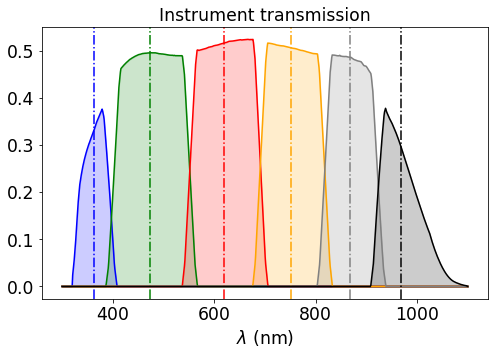

In [25]:
fig, axs = plt.subplots(1,1,figsize=(8,5))
for index in range(NFILT):
    tag="inst_"+filter_tagnames[index]
    axs.plot(WL,df_std[tag].values,color=filter_color[index]) 
    axs.fill_between(WL,df_std[tag].values,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    #plt.axvline(FILTERWL[index,0],color=filter_color[index],linestyle=":")
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Instrument transmission")

Text(0.5, 1.0, 'Instrument and atmosphere transmission')

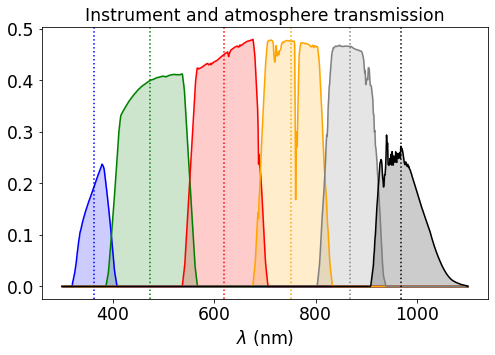

In [26]:
fig, axs = plt.subplots(1,1,figsize=(8,5))
for index in range(NFILT):
    tag="tot_"+filter_tagnames[index]
    axs.plot(WL,df_std[tag].values,color=filter_color[index]) 
    axs.fill_between(WL,df_std[tag].values,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle=":")
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Instrument and atmosphere transmission")

In [27]:
df_std.head()

wl       atm  tot_u  inst_u  tot_g  inst_g  tot_r  inst_r  tot_i  \
0  300.000000  0.006410    0.0     0.0    0.0     0.0    0.0     0.0    0.0   
1  301.001252  0.011915    0.0     0.0    0.0     0.0    0.0     0.0    0.0   
2  302.002503  0.017428    0.0     0.0    0.0     0.0    0.0     0.0    0.0   
3  303.003755  0.026622    0.0     0.0    0.0     0.0    0.0     0.0    0.0   
4  304.005006  0.035820    0.0     0.0    0.0     0.0    0.0     0.0    0.0   

   inst_i  tot_z  inst_z  tot_y  inst_y  
0     0.0    0.0     0.0    0.0     0.0  
1     0.0    0.0     0.0    0.0     0.0  
2     0.0    0.0     0.0    0.0     0.0  
3     0.0    0.0     0.0    0.0     0.0  
4     0.0    0.0     0.0    0.0     0.0

## Functions

### Functions on passband Integrals 

$$
\mathbb{I}_0(b) \equiv \int_0^\infty S_b(\lambda) \frac{d\lambda}{\lambda}
$$

In [28]:
def fII0(wl,s):
    return np.trapz(s/wl,wl)

$$
\mathbb{I}_1(b) \equiv \int_0^\infty S_b(\lambda)(\lambda - \lambda_b) \frac{d\lambda}{\lambda}
$$

In [29]:
def fII1(wl,s,wlb):
    return np.trapz(s*(wl-wlb)/wl,wl)

$$
\mathbb{I}_2(b) \equiv \int_0^\infty S_b(\lambda)(\lambda-\lambda_b)^2 \frac{d\lambda}{\lambda}
$$

In [30]:
def fII2(wl,s,wlb):
    return np.trapz(s*(wl-wlb)**2/wl,wl)

$$
\mathbb{I}_{10}(b) \equiv \frac{\mathbb{I}_{1}(b)}{\mathbb{I}_{0}(b)}
$$

In [31]:
def fII10(wl,s,wlb):
    return fII1(wl,s,wlb)/fII0(wl,s)

$$
\mathbb{I}_{20}(b) \equiv \frac{\mathbb{I}_{2}(b)}{\mathbb{I}_{0}(b)}
$$

In [32]:
def fII20(wl,s,wlb):
    return fII2(wl,s,wlb)/fII0(wl,s)

### CalculateIIntegrals(df_S,wlb)

In [33]:
def CalculateIIntegrals(df_S,wlb):
    """
    
    input : 
     - df_S : dataframe containing transmission (atmosphere + instrument) 
     - lambda_b : center of passband
     
    output:
     - dataframe containing the integrals II0,II1,II2, II10, II20 for each filter (u,g,r,i,z,y)
     
    """
    II0 = np.zeros(NFILT)
    II1 = np.zeros(NFILT)
    II2 = np.zeros(NFILT)
    II10 = np.zeros(NFILT)
    II20 = np.zeros(NFILT)
    
    for index in range(NFILT):
        tag="tot_"+filter_tagnames[index]
        wl=df_S["wl"].values
        S=df_S[tag].values
        II0[index] = fII0(wl,S)
        II1[index] = fII1(wl,S,wlb[index])
        II2[index] = fII2(wl,S,wlb[index])
        II10[index] = fII10(wl,S,wlb[index])
        II20[index] = fII20(wl,S,wlb[index])
        
    df_II = pd.DataFrame()
    df_II["II0"]=II0
    df_II["II1"]=II1
    df_II["II2"]=II2
    df_II["II10"]=II10
    df_II["II20"]=II20    
    return df_II
    

## Calculate Integrals for Standard atmosphere

### Function SED integrals

- compute average over passband

$$
\frac{
\int_0^\infty q(\lambda) S_b^{tot} \frac{d\lambda}{\lambda}
}
{
\int_0^\infty  S_b^{tot} \frac{d\lambda}{\lambda}
}
$$

In [34]:
def ComputeAverage(the_wl,the_q,df_S):
    """
    
    input parameters:
      - the_wl : the wavelength array of the quantity over which one integrate
      - the_q : the quantity over which one integrate (ex the SED flux)
      - df_S : the passbands over which one integrates
      
    output:
      - all_qq_average : average over the_q in each passband (array)
      
    """
    
    
    # quantity that must be average
    func = interpolate.interp1d(x=the_wl, y=the_q,fill_value="extrapolate")
    qq_interp = func(WL)
    
    # Output for the average
    all_qq_average= np.zeros(NFILT)
    
    # loop on filters
    for index in range(NFILT):
        tag="tot_"+filter_tagnames[index]
        wl=df_S["wl"].values
        S = df_S[tag].values
        # weight for the average
        W = S/wl
        qq_average_inband = np.sum(W*qq_interp)/W.sum()
        all_qq_average[index] = qq_average_inband
    
    return all_qq_average
        

### Calculate Integrals for Standard atmosphere

In [35]:
df_IIstd = CalculateIIntegrals(df_std,FILTERWL[:,2])

In [36]:
df_IIstd 

II0       II1         II2      II10         II20
0  0.033338  0.079194   12.612354  2.375463   378.312338
1  0.121926  0.305935  230.105550  2.509184  1887.257382
2  0.100710  0.096977  167.700718  0.962933  1665.181331
3  0.077127  0.025279  109.332320  0.327765  1417.570239
4  0.053724 -0.024968   50.296178 -0.464738   936.189562
5  0.025932  0.089871   32.480106  3.465616  1252.500277

## Creation of observed transmission and set Aerosols variation effect

- create a dataframe df_obs containing all info related to observed atmosphere

### Simulation in libradtran

In [37]:
all_aer = np.linspace(0,0.10,21)
NAER=len(all_aer)
pwv= 3
am=1.2
oz = 400

In [38]:
len(all_aer)

21

In [39]:
all_aer_tags = []
for index,aer in enumerate(all_aer):
    aer_tag = "aer_"+str(int(aer*1000))
    all_aer_tags.append(aer_tag)
all_aer_tags=np.array(all_aer_tags)
all_aer_tags

array(['aer_0', 'aer_5', 'aer_10', 'aer_15', 'aer_20', 'aer_25', 'aer_30',
       'aer_35', 'aer_40', 'aer_45', 'aer_50', 'aer_55', 'aer_60',
       'aer_65', 'aer_70', 'aer_75', 'aer_80', 'aer_85', 'aer_90',
       'aer_95', 'aer_100'], dtype='<U7')

### Read the simulation of atmosphere if already backuped and fill df_obs

In [40]:
simulation_backupfile_found = False

if FLAG_ATMSIM_READFROMFILE:
    if os.path.exists(atmsim_backup_filename):
        arr=np.loadtxt(atmsim_backup_filename)
        
        nwlsim = arr.shape[0]
        ntranspsim = arr.shape[1]
        
        #check if format is convenient
        if nwlsim == NWLBIN and ntranspsim == NAER:
            simulation_backupfile_found = True
            
            all_df_obs = []
            
            for index_aer,aer in enumerate(all_aer):
                atm = arr[:,index_aer]
                df_obs=pd.DataFrame()
                df_obs["wl"] = WL
                df_obs["atm"] = atm
                
                for findex in range(NFILT):
                    tag1="tot_"+filter_tagnames[findex]
                    tag2="inst_"+filter_tagnames[findex]
    
                    df_obs[tag1]= df_std[tag2].values*atm
                    df_obs[tag2]= df_std[tag2].values
    
                all_df_obs.append(df_obs)
        else:
            print(f"Not convenient format for file {atmsim_backup_filename}")
    else:
        print(f"file {atmsim_backup_filename} does not exist")

In [41]:
try:
    all_df_obs
except NameError:
    var_exists = False
else:
    if len(all_df_obs) >0:
        var_exists = True
    else:
        var_exists = True
var_exists

True

### If all_df_obs does not exist, then simulate 

In [42]:
if not var_exists:
    
    all_df_obs = []

    # if want to save this simulation
    if FLAG_BACKUP_ATMSIM:
        arrout = np.zeros((NWLBIN,NAER))

    # loop on airmass
    for index,aer in enumerate(all_aer):
        path,thefile = libsimulateVisible.ProcessSimulationaer(am,pwv,oz,aer,0,prof_str='us',proc_str='sa',cloudext=0.0, FLAG_VERBOSE=False)
        data = np.loadtxt(os.path.join(path,thefile))
        f = interpolate.interp1d(x=data[:,0], y=data[:,1],fill_value="extrapolate")
        atm=f(WL)
    
        # backup in simulation in the array
        if FLAG_BACKUP_ATMSIM:
            arrout[:,index]=atm 
        
    
        df_obs=pd.DataFrame()
        df_obs["wl"] = WL
        df_obs["atm"] = atm
    
    
        for findex in range(NFILT):
            tag1="tot_"+filter_tagnames[findex]
            tag2="inst_"+filter_tagnames[findex]
    
            df_obs[tag1]= df_std[tag2].values*atm
            df_obs[tag2]= df_std[tag2].values
    
        all_df_obs.append(df_obs)
        
    if FLAG_BACKUP_ATMSIM:
        np.savetxt(atmsim_backup_filename, arrout)
    

### Plot observed atmospheric  transmission and comparison with standard atmosphere

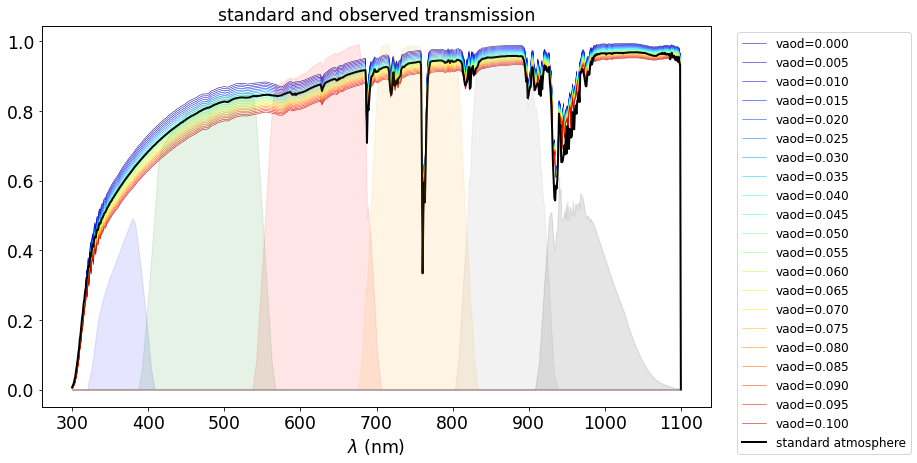

In [43]:
NOBS = len(all_df_obs)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


fig, axs = plt.subplots(1,1,figsize=(12,7))

for index,obs in enumerate(all_df_obs):
    atm = obs["atm"].values
    aer = all_aer[index]
    label = f"vaod={aer:.3f}"
    
    axs.plot(WL,atm,color=all_colors[index],label=label,lw=0.5)

    
    
axs.plot(WL,df_std["atm"].values,color="k",lw=2,label="standard atmosphere")
axs.legend(bbox_to_anchor=(1.03, 1.0))  
axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("standard and observed transmission")


ax2 = axs.twinx()
for ifilt in range(NFILT):
    tag="tot_"+filter_tagnames[ifilt]
    #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
    ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])



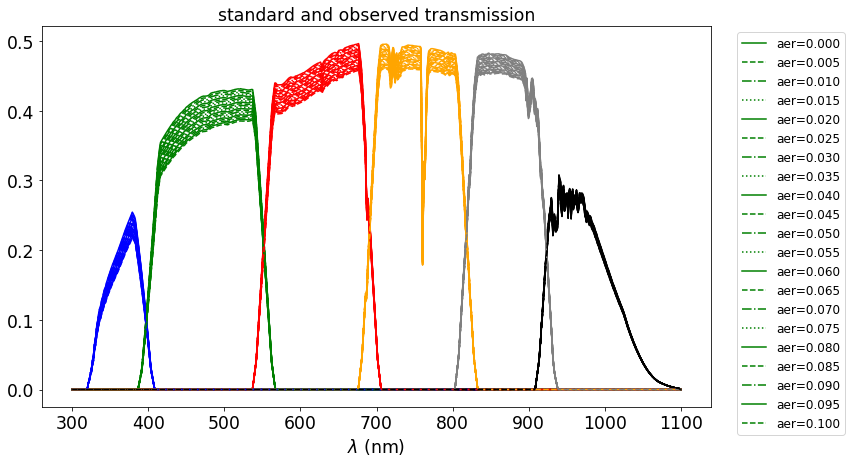

In [44]:
fig, axs = plt.subplots(1,1,figsize=(12,7))

all_linestyles = ['-','--','-.',':','-','--','-.',':','-','--','-.',':','-','--','-.',':','-','--','-.','-','--','-.','-','--','-.']


for idx_aer,the_obs in enumerate(all_df_obs):
    
    aer = all_aer[idx_aer]
    label = f"aer={aer:.3f}"
    
    for findex in range(NFILT):
        tag1="tot_"+filter_tagnames[findex]
        tag2="inst_"+filter_tagnames[findex]

        if findex==1:
            axs.plot(the_obs["wl"],the_obs[tag1],color=filter_color[findex],linestyle=all_linestyles[idx_aer],label=label )
        else:
            axs.plot(the_obs["wl"],the_obs[tag1],color=filter_color[findex],linestyle=all_linestyles[idx_aer])

axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("standard and observed transmission")
axs.legend(bbox_to_anchor=(1.03, 1.0))  

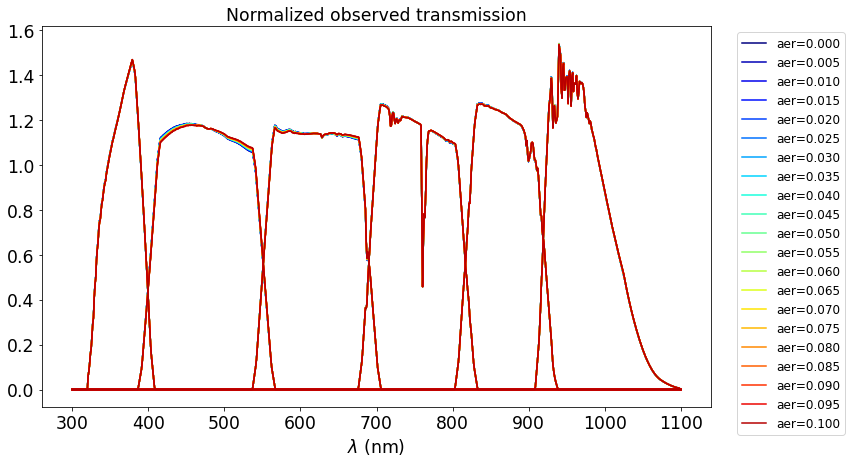

In [45]:
fig, axs = plt.subplots(1,1,figsize=(12,7))

all_linestyles = ['-','--','-.',':','-','--','-.',':','-','--','-.',':','-','--','-.',':']

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


for idx_aer,the_obs in enumerate(all_df_obs):
    
    aer = all_aer[idx_aer]
    label = f"aer={aer:.3f}"
    
   
    
    for findex in range(NFILT):
        tag1="tot_"+filter_tagnames[findex]
        tag2="inst_"+filter_tagnames[findex]

        the_II0=fII0(the_obs["wl"],the_obs[tag1])
        
        the_x=the_obs["wl"]
        the_dx=np.median(np.diff(the_x))
        the_y=the_obs[tag1]/the_II0/the_obs["wl"]*FILTERWL[findex,3]
        
        if findex==1:
            axs.plot(the_x,the_y,color=all_colors[idx_aer],linestyle="-",label=label )
        else:
            axs.plot(the_x,the_y,color=all_colors[idx_aer],linestyle="-")

axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("Normalized observed transmission")
axs.legend(bbox_to_anchor=(1.03, 1.0))  

In [46]:
all_df_obs[0].head()

wl       atm  tot_u  inst_u  tot_g  inst_g  tot_r  inst_r  tot_i  \
0  300.000000  0.003323    0.0     0.0    0.0     0.0    0.0     0.0    0.0   
1  301.001252  0.006088    0.0     0.0    0.0     0.0    0.0     0.0    0.0   
2  302.002503  0.010065    0.0     0.0    0.0     0.0    0.0     0.0    0.0   
3  303.003755  0.018388    0.0     0.0    0.0     0.0    0.0     0.0    0.0   
4  304.005006  0.022972    0.0     0.0    0.0     0.0    0.0     0.0    0.0   

   inst_i  tot_z  inst_z  tot_y  inst_y  
0     0.0    0.0     0.0    0.0     0.0  
1     0.0    0.0     0.0    0.0     0.0  
2     0.0    0.0     0.0    0.0     0.0  
3     0.0    0.0     0.0    0.0     0.0  
4     0.0    0.0     0.0    0.0     0.0

### Replace standard atmosphere with known atmosphere

In [47]:
if FLAG_REPLACE_STANDARD_ATMOS:
    df_std=all_df_obs[index_replace_atm]
    df_IIstd = CalculateIIntegrals(df_std,FILTERWL[:,2])

In [48]:
df_std.head()

wl       atm  tot_u  inst_u  tot_g  inst_g  tot_r  inst_r  tot_i  \
0  300.000000  0.003082    0.0     0.0    0.0     0.0    0.0     0.0    0.0   
1  301.001252  0.005647    0.0     0.0    0.0     0.0    0.0     0.0    0.0   
2  302.002503  0.009337    0.0     0.0    0.0     0.0    0.0     0.0    0.0   
3  303.003755  0.017061    0.0     0.0    0.0     0.0    0.0     0.0    0.0   
4  304.005006  0.021318    0.0     0.0    0.0     0.0    0.0     0.0    0.0   

   inst_i  tot_z  inst_z  tot_y  inst_y  
0     0.0    0.0     0.0    0.0     0.0  
1     0.0    0.0     0.0    0.0     0.0  
2     0.0    0.0     0.0    0.0     0.0  
3     0.0    0.0     0.0    0.0     0.0  
4     0.0    0.0     0.0    0.0     0.0

In [49]:
df_IIstd 

II0       II1         II2      II10         II20
0  0.033610  0.079828   12.692824  2.375088   377.646158
1  0.122335  0.298186  230.897377  2.437458  1887.423851
2  0.100827  0.114175  168.301284  1.132386  1669.215861
3  0.078336  0.023530  111.052462  0.300376  1417.637435
4  0.054718 -0.016277   51.747475 -0.297471   945.708886
5  0.027225  0.069754   33.459335  2.562156  1229.013361

# Integrals

## Calculate Integrals for observed atmosphere

In [50]:
all_df_IIobs = []
for idx,the_df_obs in enumerate(all_df_obs):
    the_df_IIobs = CalculateIIntegrals(the_df_obs,FILTERWL[:,2])
    all_df_IIobs.append(the_df_IIobs) 
    
    print(f"======== obs = {idx} =======")
    print(the_df_IIobs)

======== obs = 0 =======
        II0       II1         II2      II10         II20
0  0.035881  0.083467   13.548249  2.326210   377.587648
1  0.128753  0.282544  242.824553  2.194471  1885.978508
2  0.104520  0.104621  174.430673  1.000963  1668.873667
3  0.080541  0.019374  114.164780  0.240542  1417.469660
4  0.055986 -0.018867   52.942702 -0.336991   945.641327
5  0.027735  0.069655   34.053522  2.511418  1227.807921
======== obs = 1 =======
        II0       II1         II2      II10         II20
0  0.035589  0.083005   13.438236  2.332322   377.594816
1  0.127932  0.284629  241.299820  2.224842  1886.156285
2  0.104051  0.105860  173.652270  1.017390  1668.915596
3  0.080262  0.019907  113.770990  0.248021  1417.490447
4  0.055826 -0.018537   52.791792 -0.332051   945.649690
5  0.027671  0.069669   33.978666  2.517758  1227.958358
======== obs = 2 =======
        II0       II1         II2      II10         II20
0  0.035299  0.082545   13.329118  2.338432   377.602023
1  0.127117  

## Study of Integrals

In [51]:
df_IIstd 

II0       II1         II2      II10         II20
0  0.033610  0.079828   12.692824  2.375088   377.646158
1  0.122335  0.298186  230.897377  2.437458  1887.423851
2  0.100827  0.114175  168.301284  1.132386  1669.215861
3  0.078336  0.023530  111.052462  0.300376  1417.637435
4  0.054718 -0.016277   51.747475 -0.297471   945.708886
5  0.027225  0.069754   33.459335  2.562156  1229.013361

In [52]:
df_IIstd_2=df_IIstd.rename(index={0:'u',1:'g',2:'r',3:'i',4:'z',5:'y'})

In [53]:
df_IIstd_2=df_IIstd_2.transpose()

In [54]:
df_IIstd_2

u            g            r            i           z  \
II0     0.033610     0.122335     0.100827     0.078336    0.054718   
II1     0.079828     0.298186     0.114175     0.023530   -0.016277   
II2    12.692824   230.897377   168.301284   111.052462   51.747475   
II10    2.375088     2.437458     1.132386     0.300376   -0.297471   
II20  377.646158  1887.423851  1669.215861  1417.637435  945.708886   

                y  
II0      0.027225  
II1      0.069754  
II2     33.459335  
II10     2.562156  
II20  1229.013361

<AxesSubplot:title={'center':'Integrals values'}>

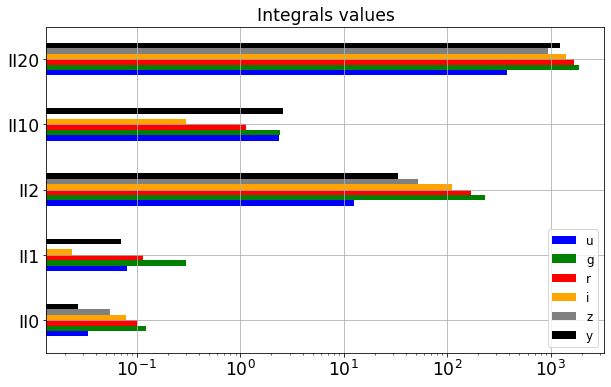

In [55]:
#my_colors = list(islice(cycle(['b', 'g', 'r', 'orange','grey','k']), None, len(df_IIstd_2)))
df_IIstd_2.plot.barh(log=True, figsize=(10,6),color=['b','g','r','orange','grey','k'],grid=True,title="Integrals values") 

## Calculate II differences

In [56]:
all_II_diff = []
for idx,aer in enumerate(all_aer):
    II_diff = all_df_IIobs[idx]-df_IIstd  
    all_II_diff.append(II_diff) 

In [57]:
all_II_div = []
for idx,aer in enumerate(all_aer):
    II_div = all_df_IIobs[idx]/df_IIstd  
    all_II_div.append(II_div) 

In [58]:
all_II_diff[15]

II0       II1       II2      II10      II20
0 -0.001854 -0.003086 -0.698396  0.041464  0.050842
1 -0.005340  0.011092 -9.930379  0.206061  1.266969
2 -0.003156  0.007298 -5.238674  0.111315  0.301739
3 -0.001923  0.003291 -2.714615  0.050626  0.144395
4 -0.001123  0.002126 -1.059334  0.033438  0.058339
5 -0.000461 -0.000032 -0.539513  0.042959  1.023510

In [59]:
all_II_diff[7].iloc[5]["II0"]

6.331268549543412e-05

## Plot integral difference between observed and standard atmosphere

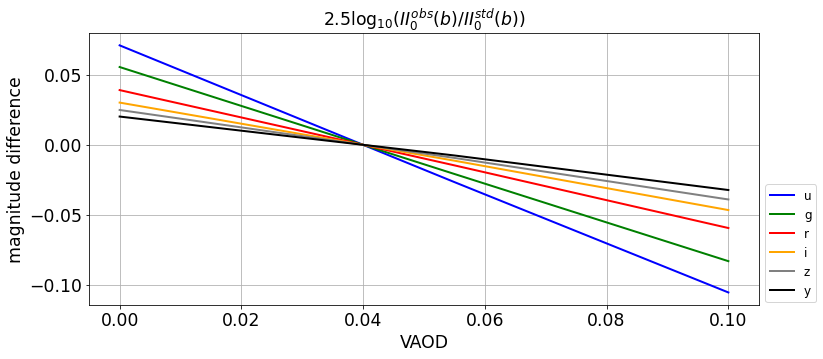

In [104]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
# loop on filters
for ifilt in range(NFILT): 
    the_div_mag = np.zeros(NAER)
    # loop on airmass to get the difference on II
    for idx,aer in enumerate(all_aer):
        the_div_mag[idx]= 2.5*np.log10(all_II_div[idx].iloc[ifilt]["II0"])
    ax.plot(all_aer,the_div_mag,color=filter_color[ifilt],label=filter_tagnames[ifilt],lw=2)
ax.set_xlabel("VAOD")
ax.set_ylabel("magnitude difference")
ax.set_title("$2.5 \log_{10} (II_0^{obs}(b)/II_0^{std}(b))$")
ax.legend(loc=(1.01, 0.01))
ax.grid()

- Magnitude corrections are of the order of 100 mmag, thus are huge. But what realu matters is the resolution on $\mathbb{I}_0^{obs}(b)$ 

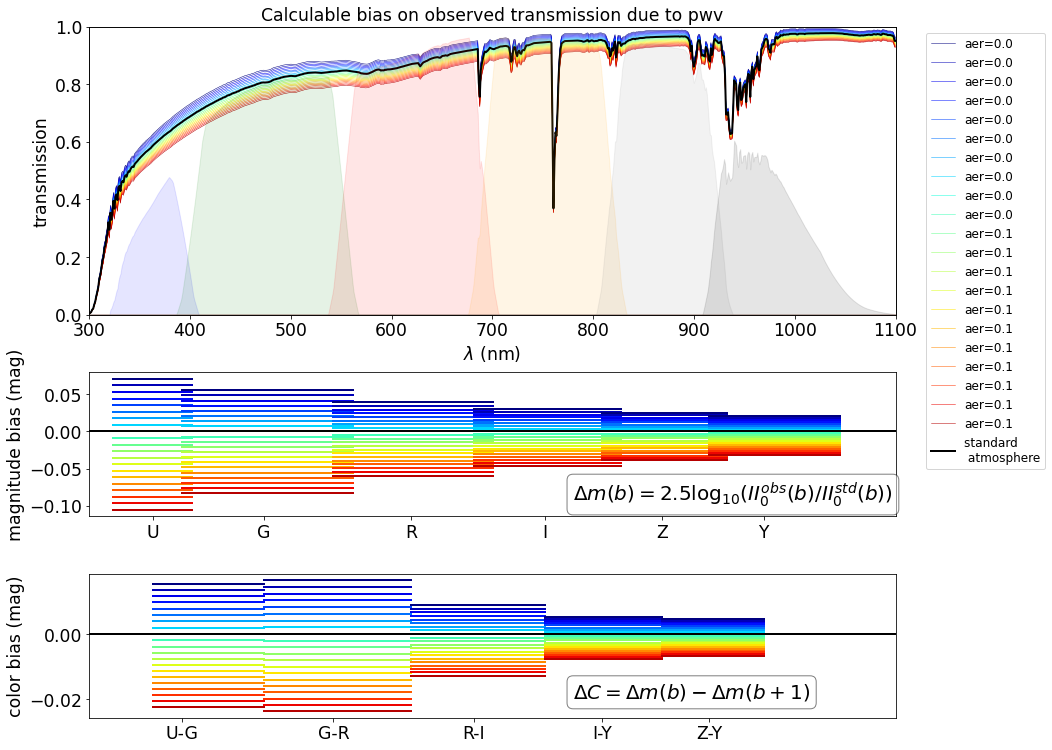

In [109]:
NOBS = len(all_df_obs)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


fig = plt.figure(figsize=(14,12))

gs = fig.add_gridspec(3, 1,  height_ratios=(3, 1.5, 1.5),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.3)

#top figure
axs = fig.add_subplot(gs[0, 0])

for index,obs in enumerate(all_df_obs):
    atm = obs["atm"].values
    aer = all_aer[index]
    label = f"aer={aer:.1f}"
    
    axs.plot(WL,atm,color=all_colors[index],label=label,lw=0.5)

    
    
axs.plot(WL,df_std["atm"].values,color="k",lw=2,label="standard \n atmosphere")
axs.legend(bbox_to_anchor=(1.03, 1.0))  
axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("Calculable bias on observed transmission due to pwv")
axs.set_xlim(WLMIN,WLMAX)
axs.set_ylim(0,1)
axs.set_ylabel("transmission")


ax2 = axs.twinx()
for ifilt in range(NFILT):
    tag="tot_"+filter_tagnames[ifilt]
    #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
    ax2.fill_between(WL,df_std[tag].values,0,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])
ax2.set_ylim(0,0.5)

#middle figure
axs2 = fig.add_subplot(gs[1, 0])
for ifilt in range(NFILT): 
    the_div_mag = np.zeros(NAER)
    # loop on airmass to get the difference on II
    for idx,aer in enumerate(all_aer):
        the_div_mag[idx]= 2.5*np.log10(all_II_div[idx].iloc[ifilt]["II0"])
        xx= [FILTERWL[ifilt,0],FILTERWL[ifilt,1]]
        yy= [the_div_mag[idx],the_div_mag[idx]]
        axs2.plot(xx,yy,color=all_colors[idx],lw=2)
axs2.set_xlim(WLMIN,WLMAX)
axs2.axhline(y=0,lw=2,color="k")
#axs2.set_xlabel("$\lambda$ (nm)")
axs2.set_xticks(FILTERWL[:,2])
axs2.set_xticklabels(Filter_tagnames, minor=False)
axs2.set_ylabel("magnitude bias (mag)")
#axs2.grid()
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='w', alpha=0.5)

textstr="$\Delta m(b) = 2.5 \log_{10} (II_0^{obs}(b)/II_0^{std}(b))$"
#axs2.set_title(textstr)
# place a text box in upper left in axes coords
axs2.text(0.6, 0.25, textstr, transform=axs2.transAxes, fontsize=20,
        verticalalignment='top', bbox=props)



# bottom figure
axs3 = fig.add_subplot(gs[2, 0])

for ifilt in range(NFILT-1): 
    the_div_mag = np.zeros(NAER)
    # loop on airmass to get the difference on II
    for idx,aer in enumerate(all_aer):
        dcolor = 2.5*np.log10(all_II_div[idx].iloc[ifilt]["II0"])- 2.5*np.log10(all_II_div[idx].iloc[ifilt+1]["II0"])
        xx= [FILTERWL[ifilt,2],FILTERWL[ifilt+1,2]]
        yy= [dcolor,dcolor]
        axs3.plot(xx,yy,color=all_colors[idx],lw=2)
axs3.set_xlim(WLMIN,WLMAX)
axs3.axhline(y=0,lw=2,color="k")
#axs3.set_xlabel("$\lambda$ (nm)")

axs3.set_xticks(FILTERWL[1:,0])
axs3.set_xticklabels(Filtercolor_tagnames, minor=False)

axs3.set_ylabel("color bias (mag)")
#axs3.grid()
textstr="$\Delta C = \Delta m(b) - \Delta m(b+1)$"
#axs2.set_title(textstr)
# place a text box in upper left in axes coords
axs3.text(0.6, 0.25, textstr, transform=axs3.transAxes, fontsize=20,
        verticalalignment='top', bbox=props)


plt.tight_layout()    

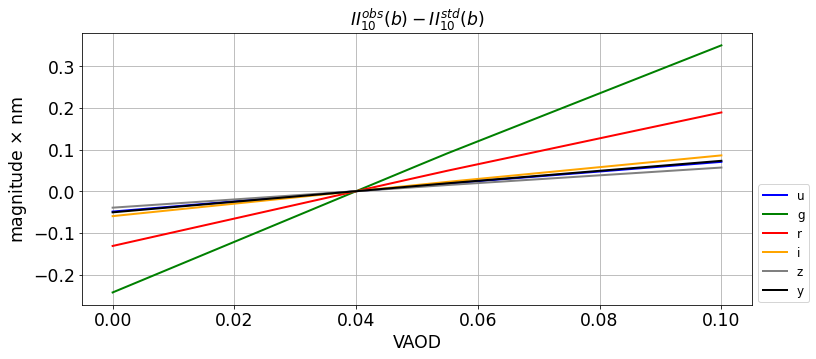

In [61]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
# loop on filters
for ifilt in range(NFILT): 
    the_diff = np.zeros(NAER)
    # loop on airmass to get the difference on II
    for idx,aer in enumerate(all_aer):
        the_diff[idx]=all_II_diff[idx].iloc[ifilt]["II10"]
    ax.plot(all_aer,the_diff,color=filter_color[ifilt],label=filter_tagnames[ifilt],lw=2)
ax.set_xlabel("VAOD")
ax.set_ylabel("magnitude $\\times$ nm")
ax.set_title("$II_{10}^{obs}(b)-II_{10}^{std}(b)$")
ax.legend(loc=(1.01, 0.01))
ax.grid()

- $\mathbb{I}_{10}^{obs}(b)-\mathbb{I}_{10}^{std}(b)$ in magnitude x nm
- It must be multiplied by $f^{\prime}(\lambda_b)$ in $nm^{-1}$

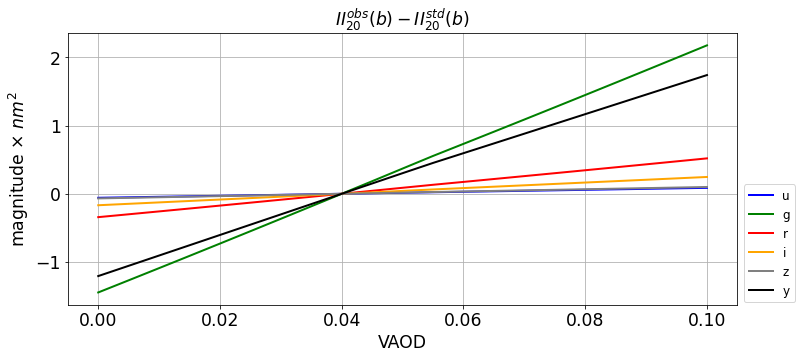

In [62]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
# loop on filters
for ifilt in range(NFILT): 
    the_diff = np.zeros(NAER)
    # loop on airmass to get the difference on II
    for idx,aer in enumerate(all_aer):
        the_diff[idx]=all_II_diff[idx].iloc[ifilt]["II20"]
    ax.plot(all_aer,the_diff,color=filter_color[ifilt],label=filter_tagnames[ifilt],lw=2)
ax.set_xlabel("VAOD")
ax.set_ylabel("magnitude $\\times \,\, nm^2$")
ax.set_title("$II_{20}^{obs}(b)-II_{20}^{std}(b)$")
ax.legend(loc=(1.01, 0.01))
ax.grid()

- $\mathbb{I}_{10}^{obs}(b)-\mathbb{I}_{10}^{std}(b)$ in magnitude x $nm^2$
- It must be multiplied by $f^{\prime\prime}(\lambda_b)$ in $nm^{-2}$

# SED

- Use SED sample from Lynne Jones
https://github.com/rhiannonlynne/photometry_sample

In [63]:
# this will contain attributes calculated for each SED
df_SED = pd.DataFrame(columns=["name","type"])

In [64]:
datadir = get_data_dir()
#sedDir = '/Users/lynnej/other_repos/photometry_sample'
sedDir = os.path.join(datadir,'photometry_sample')

sedtypes = ['galaxies', 'quasar', 'stars'] 
sedtypes_not_used = ['sn', 'photoZ_outliers', 'white_dwarf']
sedtypes = sedtypes + sedtypes_not_used

NSEDTYPES = len(sedtypes)

seds = {}
sedsfnu = {}
sedtypeslists = {}
count_sed =0

# loop on SED type
for idx,s in enumerate(sedtypes):
    sedtypelist = []
    # loop on object sed in SED type list
    filenames = os.listdir(os.path.join(sedDir, s))
    for f in filenames:
        name = f.replace('.dat', '').replace('.sed', '')
        
        if name == "m3.0Full":
            continue
            
        seds[name] = Sed()
        seds[name].readSED_flambda(os.path.join(sedDir, s, f))
        sedsfnu[name]= Sed()
    
        # save the name of the sed in the list
        sedtypelist.append(name) 
        df_SED.loc[count_sed] = [name,s]
        count_sed+=1
        
    # save the above list in a dictionary
    sedtypeslists[s] =  sedtypelist
        

In [65]:
df_SED=df_SED.set_index('name')
df_SED

type
name                               
Sa_template_norm           galaxies
Sdm_template_norm0         galaxies
Ell2_template_norm         galaxies
quasar                       quasar
km10_5250.fits_g45            stars
km10_4500.fits_g45            stars
km10_6000.fits_g45            stars
km10_7250.fits_g45            stars
km10_6500.fits_g45            stars
sn1a_10.0                        sn
sn1a_15.0                        sn
sn1a_20.0                        sn
xspec_173           photoZ_outliers
xspec_172           photoZ_outliers
xspec_90            photoZ_outliers
xspec_91            photoZ_outliers
xspec_176           photoZ_outliers
xspec_175           photoZ_outliers
wd_He_5500_80           white_dwarf
wd_H_5500_80            white_dwarf
wd_He_15000_80          white_dwarf
wd_H_50000_80           white_dwarf
wd_He_10000_80          white_dwarf
wd_H_100000_80          white_dwarf
wd_H_15000_80           white_dwarf

In [66]:
#list(seds.keys())

In [67]:
#sedtypeslists

In [68]:
NSED = len(list(seds.keys()))

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NSED)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NSED), alpha=1)

In [69]:
# Redshift the quasar. Note repeat calls to this cell will stack, increasing the redshift multiple times.
z=1.5
seds['quasar'].redshiftSED(z)

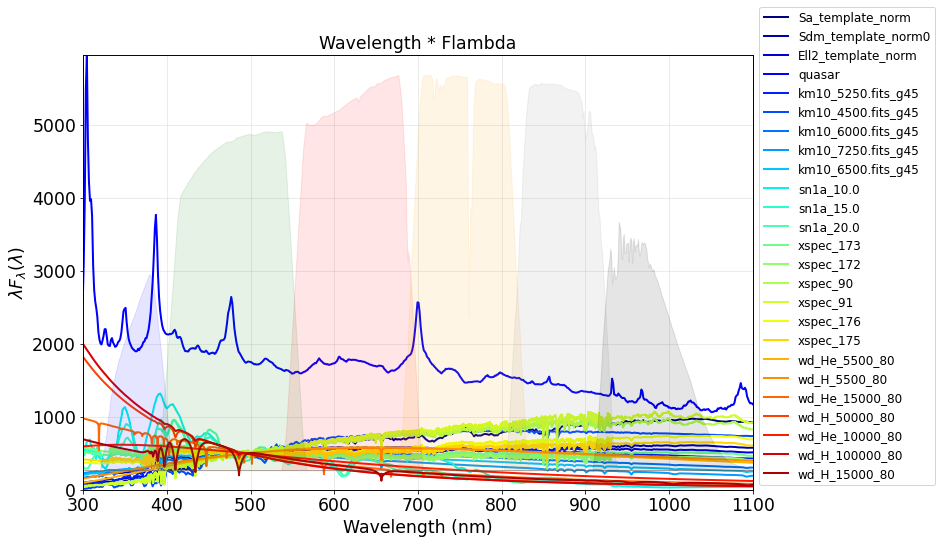

In [70]:
# Plot the seds
fig, ax = plt.subplots(1,1,figsize=(12,8))

sedmax=0
# loop on SED
for idx,n in enumerate(seds):
    ax.plot(seds[n].wavelen, seds[n].flambda * seds[n].wavelen, color=all_colors[idx],label=n,lw=2)
    
    fl = seds[n].flambda * seds[n].wavelen
    wav= seds[n].wavelen
    fl = fl[np.where(np.logical_and(wav>=WLMIN,wav<=WLMAX))[0]]
    sedmax=max(sedmax,fl.max()) 
    
    
ax.legend(loc=(1.01, 0.01))
ax.set_xlim(300, 1100)
ax.set_ylim(0, sedmax)
ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$\lambda F_\lambda(\lambda)$")
ax.set_title("Wavelength * Flambda")

ax2 = ax.twinx()
for ifilt in range(NFILT):
    tag="tot_"+filter_tagnames[ifilt]
    #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
    ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])

- m3 is a gmobular Cluster Messier 3 or NGC 5272

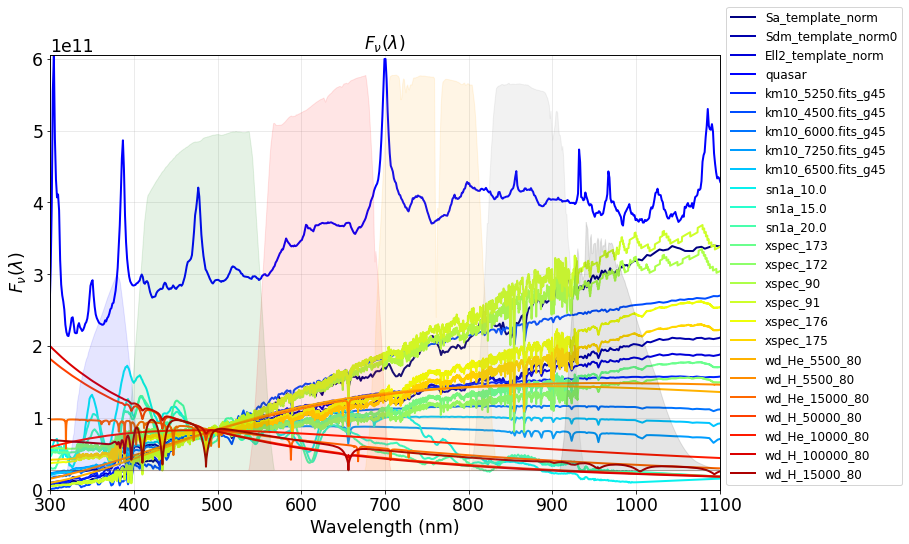

In [71]:
# Plot the seds
fig, ax = plt.subplots(1,1,figsize=(12,8))

# loop on SED
sedmax=0
for idx,name in enumerate(seds):
    wavel,fnu = seds[name].getSED_fnu()
    ax.plot(wavel, fnu, color=all_colors[idx],label=name,lw=2)
    
    
    fl = fnu
    wav= wavel
    fl = fl[np.where(np.logical_and(wav>=WLMIN,wav<=WLMAX))[0]]
    sedmax=max(sedmax,fl.max()) 
    
ax.legend(loc=(1.01, 0.01))
ax.set_xlim(300, 1100)
ax.set_ylim(0, sedmax)

ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$F_\\nu (\lambda)$")
ax.set_title("$F_\\nu (\lambda)$")

ax2 = ax.twinx()
for ifilt in range(NFILT):
    tag="tot_"+filter_tagnames[ifilt]
    #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
    ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])

In [72]:
sedtypeslists["galaxies"]

['Sa_template_norm', 'Sdm_template_norm0', 'Ell2_template_norm']

In [73]:
wav

array([ 300. ,  300.1,  300.2, ..., 1199.8, 1199.9, 1200. ])

In [74]:
np.where(np.logical_and(wav>=WLMIN,wav<=WLMAX))[0]

array([   0,    1,    2, ..., 7998, 7999, 8000])

Text(0.5, 1.0, 'SED $\\lambda F_\\lambda$')

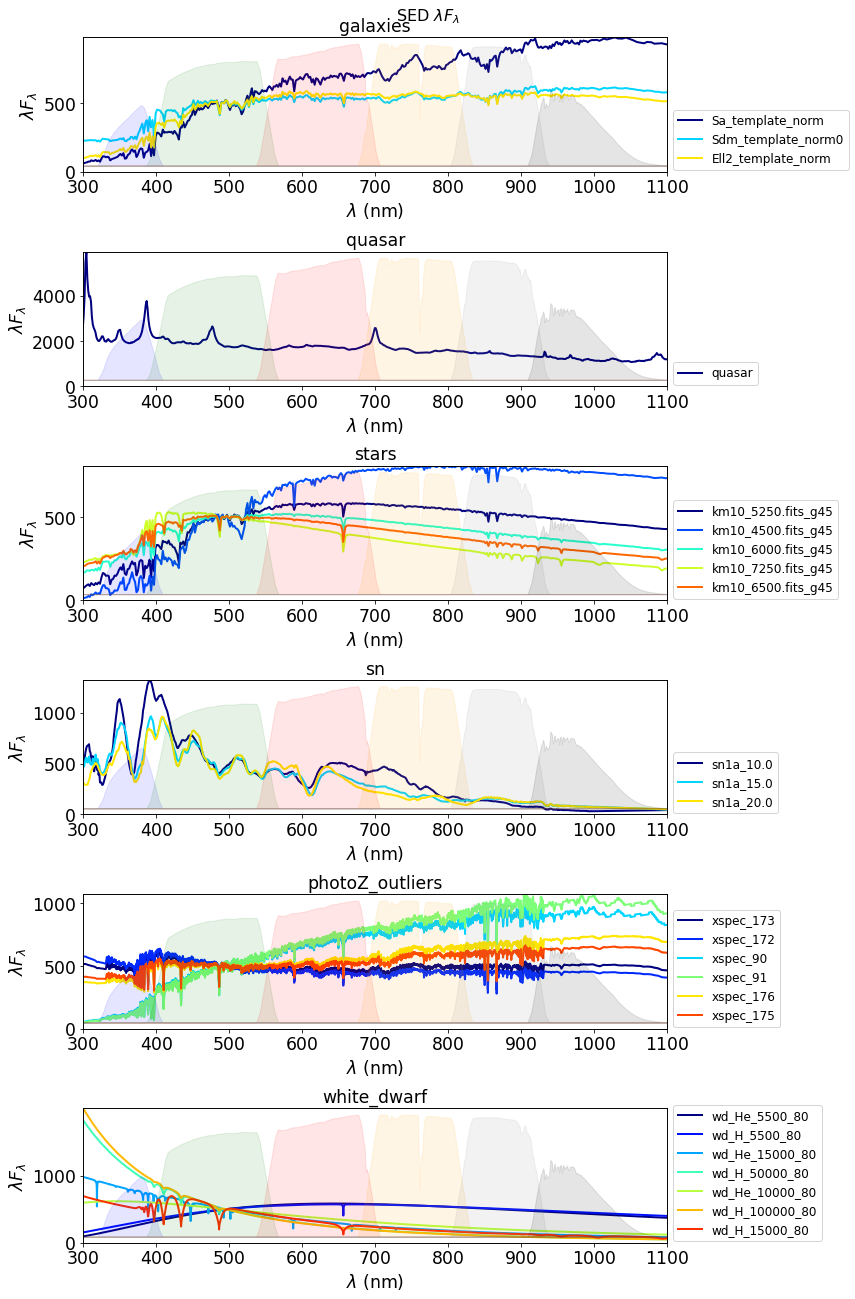

In [75]:
fig, axs = plt.subplots(NSEDTYPES,1,figsize=(12,NSEDTYPES*3))


# loop on all SED types
for idx,s in enumerate(sedtypes):
    
    
    sednamelist = sedtypeslists[s] 
    NSEDs = len(sednamelist)
    
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NSEDs)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NSEDs), alpha=1)
    
    # loop on the SED of a given type
    sedmax=0
    for idx0,name in  enumerate(sednamelist):
        axs[idx].plot(seds[name].wavelen, seds[name].flambda * seds[name].wavelen, color=all_colors[idx0],label=name,lw=2)
        #compute SED max
        fl = seds[name].flambda * seds[name].wavelen
        wav= seds[name].wavelen
        fl = fl[np.where(np.logical_and(wav>=WLMIN,wav<=WLMAX))[0]]
        sedmax=max(sedmax,fl.max()) 
    
    axs[idx].set_ylim(0,sedmax)
    axs[idx].legend(loc=(1.01, 0.01))
    axs[idx].set_title(s)
    axs[idx].set_xlim(WLMIN,WLMAX)
    axs[idx].set_xlabel('$\lambda$ (nm)')
    axs[idx].set_ylabel("$\lambda F_\lambda$")
    
    
    ax2 = axs[idx].twinx()
    for ifilt in range(NFILT):
        tag="tot_"+filter_tagnames[ifilt]
        #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
        ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
        ax2.set_yticks([])
    
    
plt.tight_layout()
plt.suptitle("SED $\\lambda F_\\lambda$",fontsize=16,y=1.0)

Text(0.5, 1.01, 'SED $F_\\nu$')

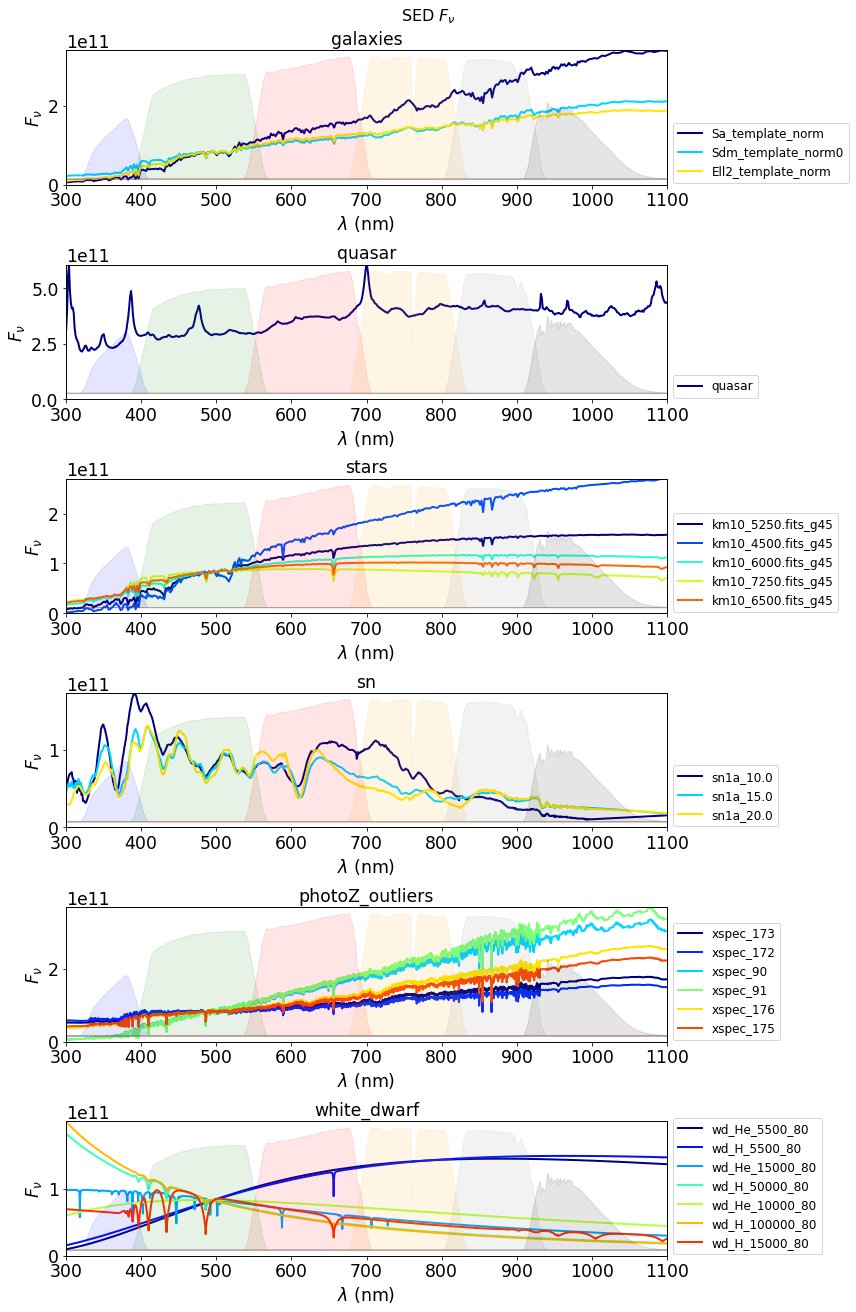

In [76]:
fig, axs = plt.subplots(NSEDTYPES,1,figsize=(12,NSEDTYPES*3))

# loop on SED types
for idx,s in enumerate(sedtypes):
    
    sednamelist = sedtypeslists[s] 
    NSEDs = len(sednamelist)
    
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NSEDs)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NSEDs), alpha=1)
    
    sedmax=0
    # loop on objects in sedtypes
    for idx0,name in  enumerate(sednamelist):
        wavel,fnu = seds[name].getSED_fnu()
        axs[idx].plot(wavel, fnu , color=all_colors[idx0],label=name,lw=2)
        #compute SED max
        fl = fnu
        wav= wavel
        fl = fl[np.where(np.logical_and(wav>=WLMIN,wav<=WLMAX))[0]]
        sedmax=max(sedmax,fl.max()) 
        
    axs[idx].set_ylim(0,sedmax)
    axs[idx].legend(loc=(1.01, 0.01))
    axs[idx].set_title(s)
    axs[idx].set_xlim(WLMIN,WLMAX)
    axs[idx].set_xlabel('$\lambda$ (nm)')
    axs[idx].set_ylabel("$F_\\nu$")
    
    ax2 = axs[idx].twinx()
    for ifilt in range(NFILT):
        tag="tot_"+filter_tagnames[ifilt]
        #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
        ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
        ax2.set_yticks([])
    
    
plt.tight_layout()
plt.suptitle("SED $F_\\nu$",fontsize=16,y=1.01)

Text(0.5, 1.01, 'SED $f^\\prime_\\nu$')

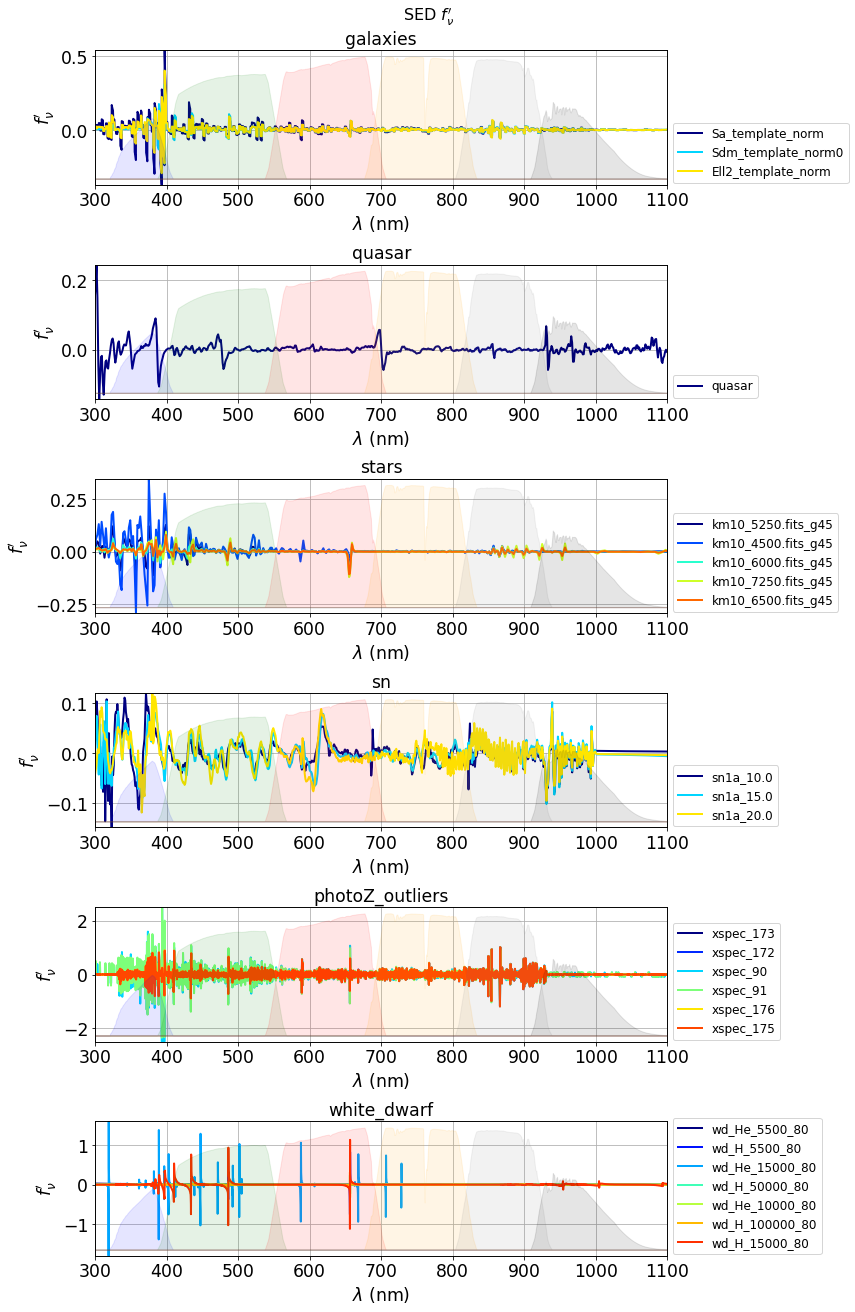

In [77]:
fig, axs = plt.subplots(NSEDTYPES,1,figsize=(12,NSEDTYPES*3))


# loop on SED types
for idx,s in enumerate(sedtypes):
    
    sednamelist = sedtypeslists[s] 
    NSEDs = len(sednamelist)
    
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NSEDs)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NSEDs), alpha=1)
    
    sedmin=0
    sedmax=0
    
    #loop on object in sedtype
    for idx0,name in  enumerate(sednamelist):
        wavel,fnu = seds[name].getSED_fnu()
        x=wavel
        y = fnu
        fnup=np.gradient(y, x)
        fratio = fnup/fnu
        axs[idx].plot(wavel, fratio , color=all_colors[idx0],label=name,lw=2)
        
        #compute SED max
        fl = fratio
        wav= wavel
        fl = fl[np.where(np.logical_and(wav>=WLMIN,wav<=WLMAX))[0]]
        sedmax=max(sedmax,fl.max()) 
        sedmin=min(sedmin,fl.min()) 
        
    axs[idx].legend(loc=(1.01, 0.01))
    axs[idx].set_title(s)
    axs[idx].set_xlim(WLMIN,WLMAX)
    axs[idx].set_ylim(sedmin,sedmax)
    axs[idx].set_xlabel('$\lambda$ (nm)')
    axs[idx].set_ylabel("$f^\prime_\\nu$")
    axs[idx].grid()
    
    ax2 = axs[idx].twinx()
    for ifilt in range(NFILT):
        tag="tot_"+filter_tagnames[ifilt]
        #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
        ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
        ax2.set_yticks([])
    
plt.tight_layout()
plt.suptitle("SED $f^\prime_\\nu$",fontsize=16,y=1.01)

Text(0.5, 1.01, 'SED $f^{\\prime\\prime}_\\nu$')

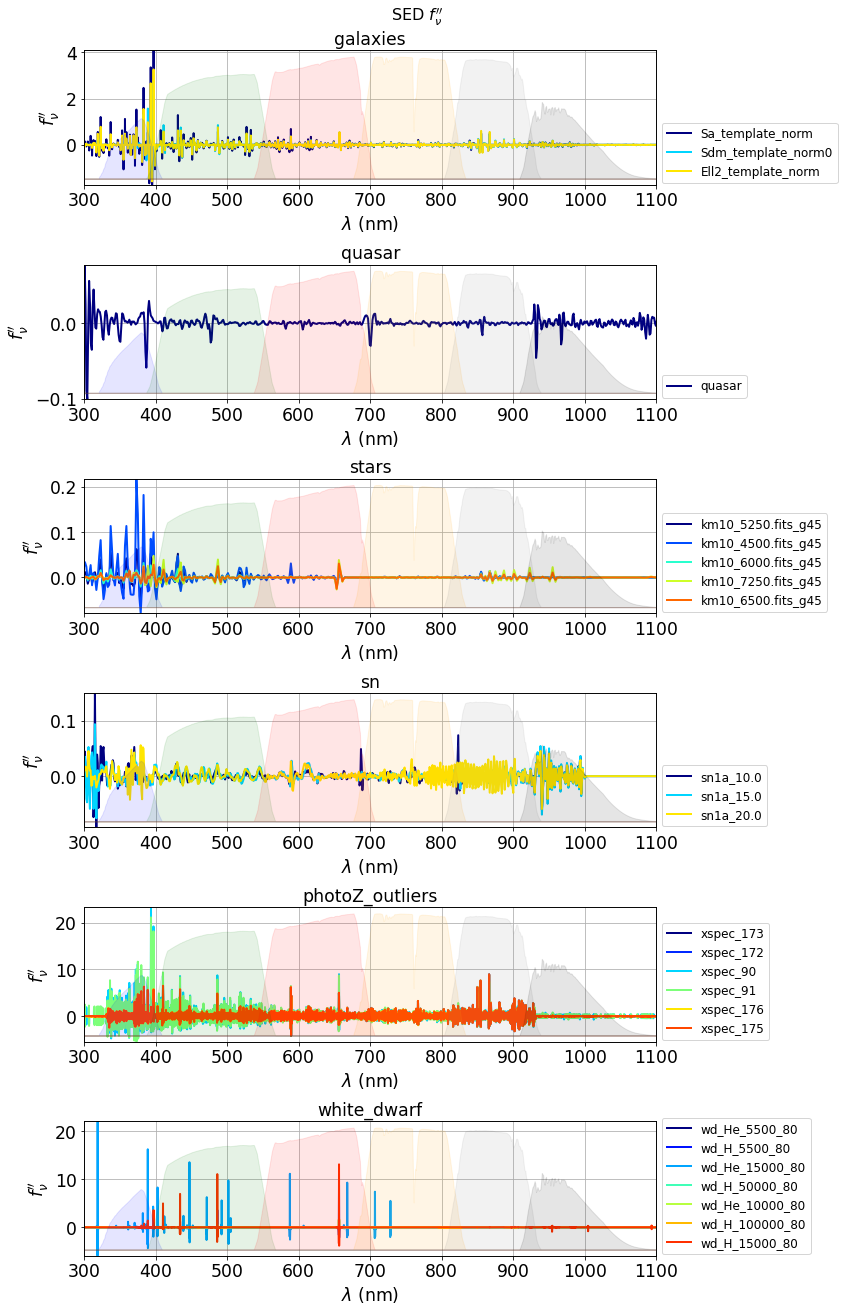

In [78]:
fig, axs = plt.subplots(NSEDTYPES,1,figsize=(12,NSEDTYPES*3))

for idx,s in enumerate(sedtypes):
    
    sednamelist = sedtypeslists[s] 
    NSEDs = len(sednamelist)
    
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NSEDs)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NSEDs), alpha=1)
    
    
    #loop on objects in sed type list
    sedmin=0
    sedmax=0
    for idx0,name in  enumerate(sednamelist):
        wavel,fnu = seds[name].getSED_fnu()
        x=wavel
        y = fnu
        fnup=np.gradient(y, x)
        fnupp = np.gradient(fnup,x)
        fratio = fnupp/fnu
        axs[idx].plot(wavel, fratio , color=all_colors[idx0],label=name,lw=2)
        
        #compute SED max
        fl = fratio
        wav= wavel
        fl = fl[np.where(np.logical_and(wav>=WLMIN,wav<=WLMAX))[0]]
        sedmax=max(sedmax,fl.max()) 
        sedmin=min(sedmin,fl.min()) 
        
        
    axs[idx].legend(loc=(1.01, 0.01))
    axs[idx].set_title(s)
    axs[idx].set_xlim(WLMIN,WLMAX)
    axs[idx].set_ylim(sedmin,sedmax)
    axs[idx].set_xlabel('$\lambda$ (nm)')
    axs[idx].set_ylabel("$f^{\prime\prime}_\\nu$")
    axs[idx].grid()
    
    ax2 = axs[idx].twinx()
    for ifilt in range(NFILT):
        tag="tot_"+filter_tagnames[ifilt]
        #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
        ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
        ax2.set_yticks([])
    
plt.tight_layout()
plt.suptitle("SED $f^{\prime\prime}_\\nu$",fontsize=16,y=1.01)

# Filtering the SED

In [79]:
def smooth_data_convolve_my_average(arr, span):
    re = np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

    # The "my_average" part: shrinks the averaging window on the side that 
    # reaches beyond the data, keeps the other side the same size as given 
    # by "span"
    re[0] = np.average(arr[:span])
    for i in range(1, span + 1):
        re[i] = np.average(arr[:i + span])
        re[-i] = np.average(arr[-i - span:])
    return re

def smooth_data_np_average(arr, span):  # my original, naive approach
    return [np.average(arr[val - span:val + span + 1]) for val in range(len(arr))]

def smooth_data_np_convolve(arr, span):
    return np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

def smooth_data_np_cumsum_my_average(arr, span):
    cumsum_vec = np.cumsum(arr)
    moving_average = (cumsum_vec[2 * span:] - cumsum_vec[:-2 * span]) / (2 * span)

    # The "my_average" part again. Slightly different to before, because the
    # moving average from cumsum is shorter than the input and needs to be padded
    front, back = [np.average(arr[:span])], []
    for i in range(1, span):
        front.append(np.average(arr[:i + span]))
        back.insert(0, np.average(arr[-i - span:]))
    back.insert(0, np.average(arr[-2 * span:]))
    return np.concatenate((front, moving_average, back))

def smooth_data_lowess(arr, span):
    x = np.linspace(0, 1, len(arr))
    return sm.nonparametric.lowess(arr, x, frac=(5*span / len(arr)), return_sorted=False)

def smooth_data_kernel_regression(arr, span):
    # "span" smoothing parameter is ignored. If you know how to 
    # incorporate that with kernel regression, please comment below.
    kr = KernelReg(arr, np.linspace(0, 1, len(arr)), 'c')
    return kr.fit()[0]

def smooth_data_savgol_0(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 0)

def smooth_data_savgol_1(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 1)

def smooth_data_savgol_2(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 2)

def smooth_data_fft(arr, span):  # the scaling of "span" is open to suggestions
    w = fftpack.rfft(arr)
    spectrum = w ** 2
    cutoff_idx = spectrum < (spectrum.max() * (1 - np.exp(-span / 2000)))
    w[cutoff_idx] = 0
    return fftpack.irfft(w)


In [80]:
# filtering width in nm
span=150

Text(0.5, 1.01, 'Filtered SED $F_\\nu$')

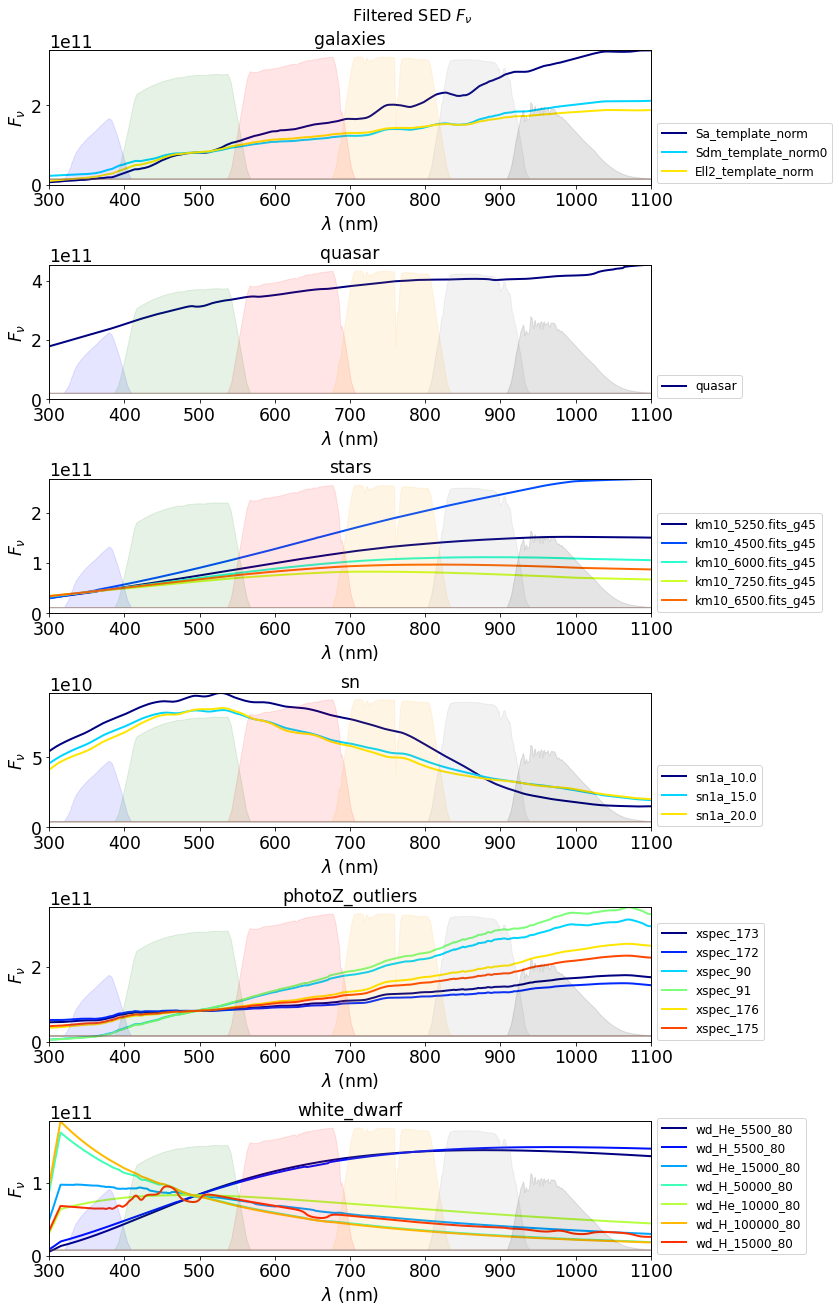

In [81]:
fig, axs = plt.subplots(NSEDTYPES,1,figsize=(12,NSEDTYPES*3))

for idx,s in enumerate(sedtypes):
    
    sednamelist = sedtypeslists[s] 
    NSEDs = len(sednamelist)
    
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NSEDs)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NSEDs), alpha=1)
    
    
    sedmin=0
    sedmax=0
    for idx0,name in  enumerate(sednamelist):
        wavel,fnu = seds[name].getSED_fnu()
        
        fnu_filtered = smooth_data_np_convolve(fnu, span)
        
        axs[idx].plot(wavel, fnu_filtered , color=all_colors[idx0],label=name,lw=2)
        
        #compute SED max
        fl = fnu_filtered
        wav= wavel
        fl = fl[np.where(np.logical_and(wav>=WLMIN,wav<=WLMAX))[0]]
        sedmax=max(sedmax,fl.max()) 
        sedmin=min(sedmin,fl.min()) 
        
        
    axs[idx].legend(loc=(1.01, 0.01))
    axs[idx].set_title(s)
    axs[idx].set_xlim(WLMIN,WLMAX)
    axs[idx].set_ylim(0,sedmax)
    axs[idx].set_xlabel('$\lambda$ (nm)')
    axs[idx].set_ylabel("$F_\\nu$")
    
    ax2 = axs[idx].twinx()
    for ifilt in range(NFILT):
        tag="tot_"+filter_tagnames[ifilt]
        #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
        ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
        ax2.set_yticks([])
    
    
plt.tight_layout()
plt.suptitle("Filtered SED $F_\\nu$",fontsize=16,y=1.01)

Text(0.5, 1.01, 'Filtered SED $f^\\prime_\\nu$')

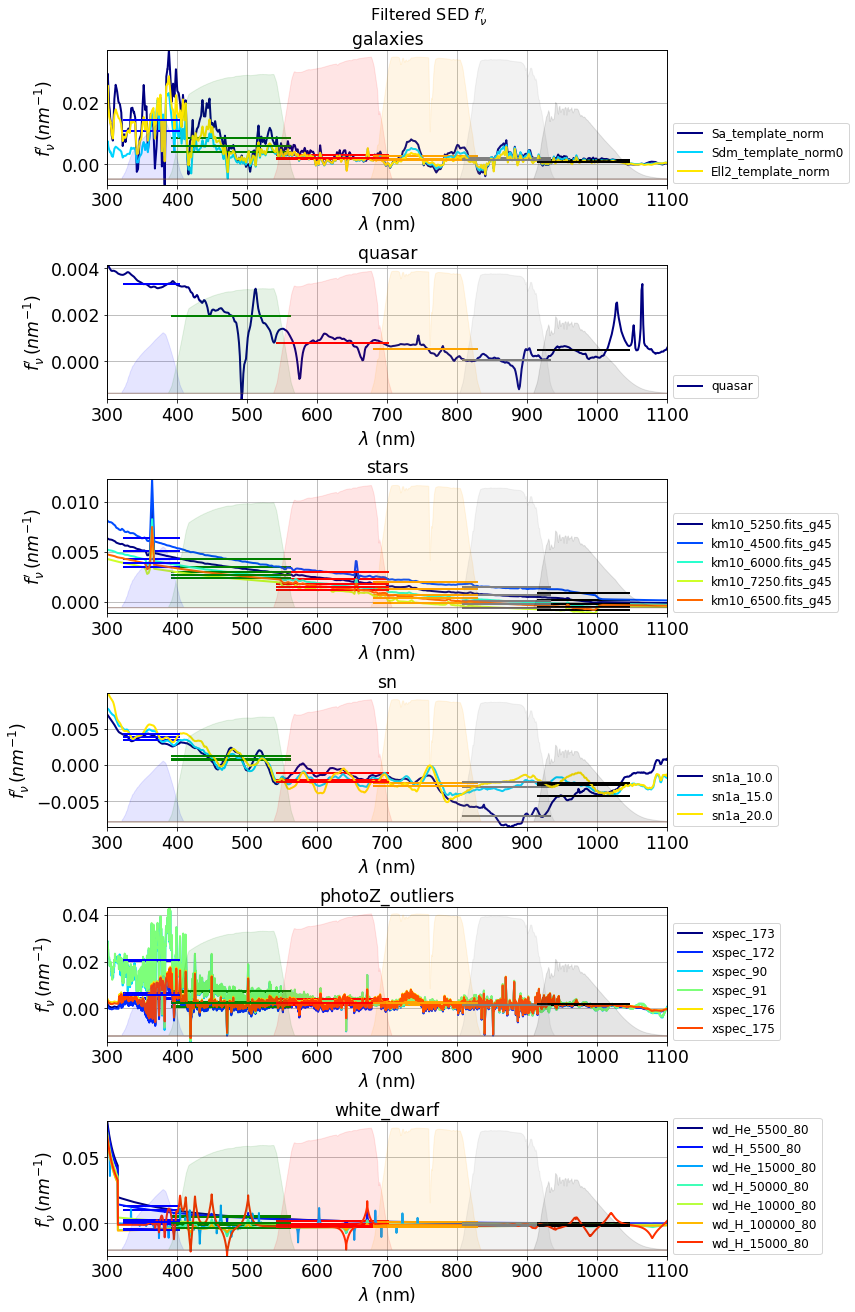

In [82]:
fig, axs = plt.subplots(NSEDTYPES,1,figsize=(12,NSEDTYPES*3))

df_fp = pd.DataFrame(columns=["fp_u","fp_g","fp_r","fp_i","fp_z","fp_y"])

for idx,s in enumerate(sedtypes):
    
    sednamelist = sedtypeslists[s] 
    NSEDs = len(sednamelist)
    
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NSEDs)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NSEDs), alpha=1)
    
    sedmin=0
    sedmax=0
    # loop on object in sed type
    for idx0,name in  enumerate(sednamelist):
        wavel,fnu = seds[name].getSED_fnu()
        fnu_filtered = smooth_data_np_convolve(fnu, span)
        x=wavel
        y = fnu_filtered
        fnup=np.gradient(y, x)
        fratio = fnup/fnu_filtered
        axs[idx].plot(wavel, fratio , color=all_colors[idx0],label=name,lw=2)
        
        #compute SED max
        fl = fratio
        wav= wavel
        fl = fl[np.where(np.logical_and(wav>=WLMIN,wav<=WLMAX))[0]]
        sedmax=max(sedmax,fl.max()) 
        sedmin=min(sedmin,fl.min()) 
        
        
        # average fp
        fp_filters = ComputeAverage(x,fratio,df_std)
        for ifilt in range(NFILT):
            axs[idx].plot([FILTERWL[ifilt,0],FILTERWL[ifilt,1]],[fp_filters[ifilt],fp_filters[ifilt]],color=filter_color[ifilt],lw=2)
        df_fp.loc[name] = fp_filters     
        
    axs[idx].legend(loc=(1.01, 0.01))
    axs[idx].set_title(s)
    axs[idx].set_xlim(WLMIN,WLMAX)
    axs[idx].set_ylim(sedmin,sedmax)
    axs[idx].set_xlabel('$\lambda$ (nm)')
    axs[idx].set_ylabel("$f^\prime_\\nu \, (nm^{-1})$")
    axs[idx].grid()
    
    ax2 = axs[idx].twinx()
    for ifilt in range(NFILT):
        tag="tot_"+filter_tagnames[ifilt]
        #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
        ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
        ax2.set_yticks([])
    
plt.tight_layout()
plt.suptitle("Filtered SED $f^\prime_\\nu$",fontsize=16,y=1.01)

In [83]:
df_fp

fp_u      fp_g      fp_r      fp_i      fp_z      fp_y
Sa_template_norm    0.014306  0.008547  0.002844  0.002649  0.002083  0.001375
Sdm_template_norm0  0.010860  0.003987  0.001750  0.001753  0.001762  0.001118
Ell2_template_norm  0.014341  0.006005  0.001870  0.001270  0.001197  0.000739
quasar              0.003326  0.001947  0.000775  0.000516  0.000041  0.000484
km10_5250.fits_g45  0.005114  0.003498  0.002283  0.001227  0.000612  0.000162
km10_4500.fits_g45  0.006372  0.004272  0.002939  0.001961  0.001412  0.000867
km10_6000.fits_g45  0.004269  0.002959  0.001739  0.000667  0.000075 -0.000287
km10_7250.fits_g45  0.003431  0.002358  0.001123 -0.000107 -0.000626 -0.000824
km10_6500.fits_g45  0.003866  0.002683  0.001449  0.000341 -0.000216 -0.000517
sn1a_10.0           0.003489  0.000853 -0.001154 -0.002957 -0.007070 -0.004344
sn1a_15.0           0.003937  0.000748 -0.002065 -0.002479 -0.003088 -0.002754
sn1a_20.0           0.004263  0.001236 -0.002352 -0.002940 -0.002310 -0.002469
xspec_173           0.004547  0.001143  0.001475  0.001794  0.001066  0.001464
xspec_172           0.003926  0.000696  0.001169  0.001567  0.000896  0.001328
xspec_90            0.020093  0.007143  0.003538  0.002193  0.001735  0.001329
xspec_91            0.020620  0.007497  0.003793  0.002361  0.001873  0.001416
xspec_176           0.006403  0.002486  0.002389  0.002474  0.001574  0.001868
xspec_175           0.005785  0.002038  0.002086  0.002248  0.001406  0.001734
wd_He_5500_80       0.012813  0.005625  0.001918  0.000607  0.000040 -0.000243
wd_H_5500_80        0.009869  0.004864  0.001935  0.000783  0.000259 -0.000006
wd_He_15000_80     -0.000836 -0.001312 -0.001939 -0.001700 -0.001665 -0.001558
wd_H_50000_80      -0.004506 -0.003360 -0.002984 -0.002476 -0.002161 -0.001934
wd_He_10000_80      0.002238  0.000139 -0.000867 -0.001139 -0.001207 -0.001209
wd_H_100000_80     -0.004912 -0.003766 -0.003050 -0.002521 -0.002193 -0.001965
wd_H_15000_80       0.000538  0.000450 -0.002334 -0.001910 -0.001608 -0.001614

In [84]:
df_fp.describe()

fp_u       fp_g       fp_r       fp_i       fp_z       fp_y
count  25.000000  25.000000  25.000000  25.000000  25.000000  25.000000
mean    0.006166   0.002509   0.000733   0.000247  -0.000245  -0.000234
std     0.006448   0.003084   0.002134   0.001920   0.002085   0.001649
min    -0.004912  -0.003766  -0.003050  -0.002957  -0.007070  -0.004344
25%     0.003431   0.000748  -0.001154  -0.001700  -0.001608  -0.001558
50%     0.004269   0.002358   0.001475   0.000667   0.000075  -0.000006
75%     0.009869   0.004272   0.002086   0.001794   0.001406   0.001328
max     0.020620   0.008547   0.003793   0.002649   0.002083   0.001868

<AxesSubplot:title={'center':'$f_\\nu^{\\prime}$'}, ylabel='$f^{\\prime}_\\nu \\quad (nm^{-1})$'>

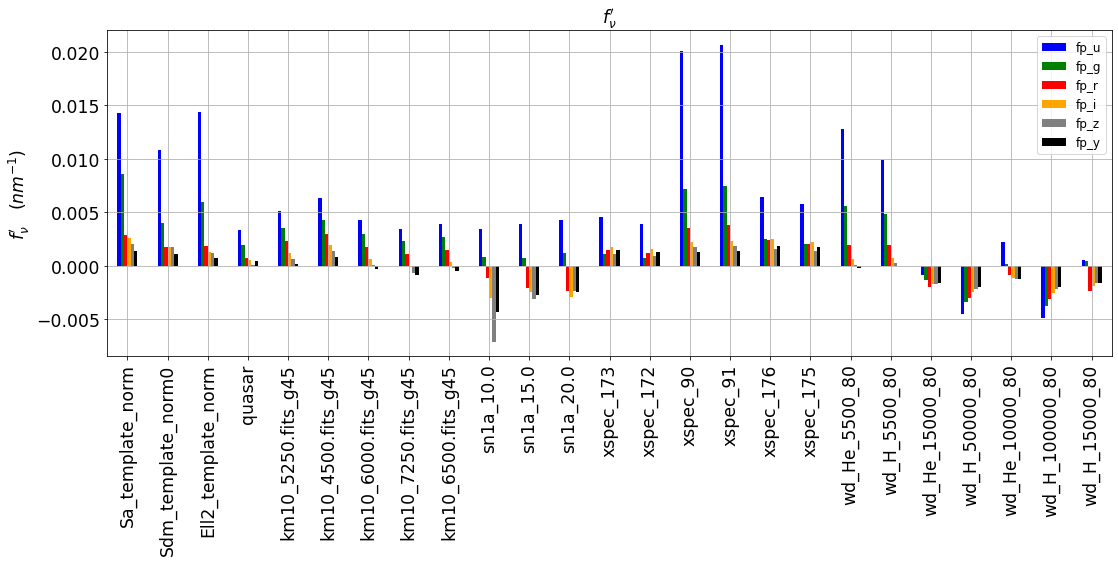

In [85]:
my_colors = list(islice(cycle(['b', 'g', 'r', 'orange','grey','k']), None, len(df_fp)))
df_fp.plot.bar(figsize=(18,6),ylabel="$f^{\prime}_\\nu \quad (nm^{-1})$",grid=True,color=my_colors,title="$f_\\nu^{\prime}$")

Text(0.5, 1.01, 'Filtered SED $f^{\\prime\\prime}_\\nu$')

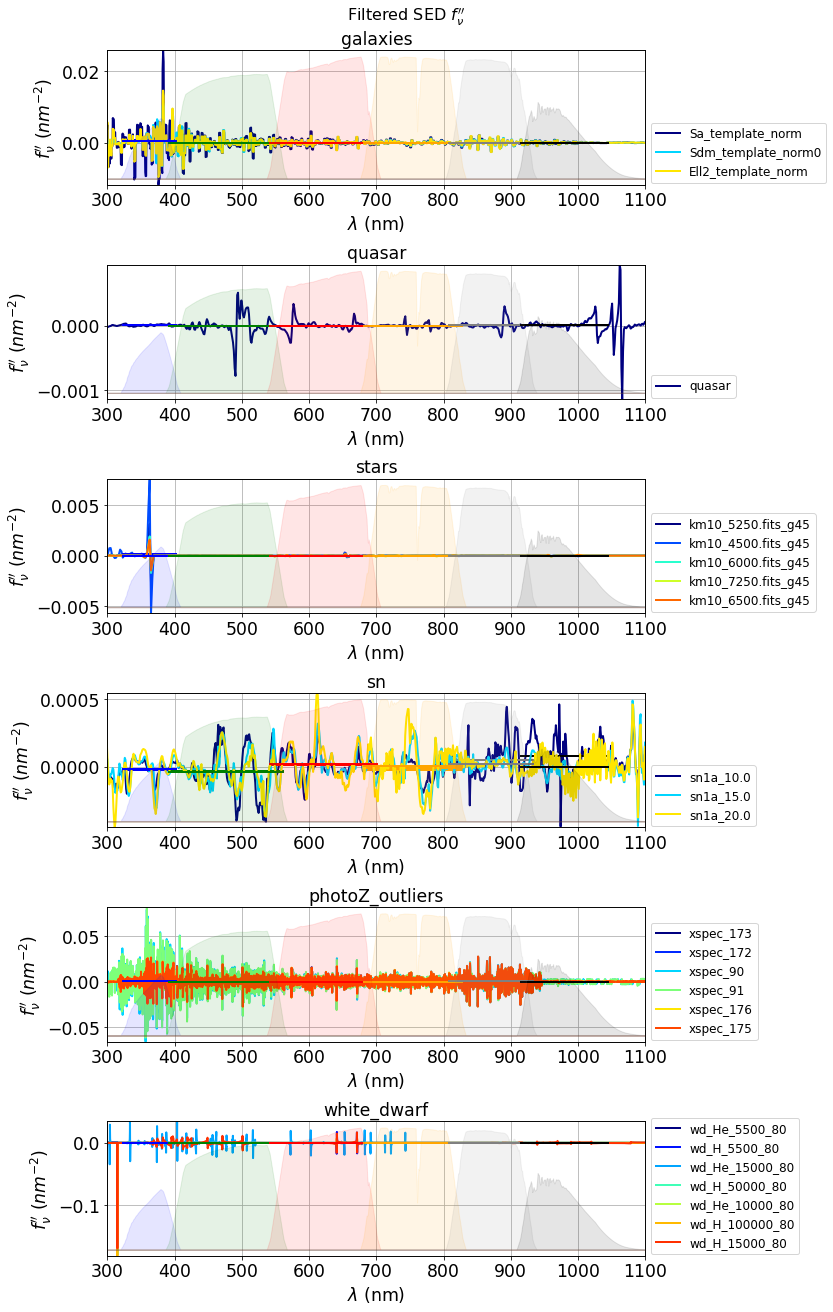

In [86]:
fig, axs = plt.subplots(NSEDTYPES,1,figsize=(12,NSEDTYPES*3))

df_fpp = pd.DataFrame(columns=["fpp_u","fpp_g","fpp_r","fpp_i","fpp_z","fpp_y"])

# loop on sedtypes
for idx,s in enumerate(sedtypes):
    
    sednamelist = sedtypeslists[s] 
    NSEDs = len(sednamelist)
    
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NSEDs)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NSEDs), alpha=1)
    
    #loop on object in sedypes
    sedmax=0
    sedmin=0
    
    for idx0,name in  enumerate(sednamelist):
        wavel,fnu = seds[name].getSED_fnu()
        fnu_filtered = smooth_data_np_convolve(fnu, span)
        x=wavel
        y = fnu_filtered
        fnup=np.gradient(y, x)
        fnupp = np.gradient(fnup,x)
        fratio = fnupp/fnu
        axs[idx].plot(wavel, fratio , color=all_colors[idx0],label=name,lw=2)
        
        #compute SED max
        fl = fratio
        wav= wavel
        fl = fl[np.where(np.logical_and(wav>=WLMIN,wav<=WLMAX))[0]]
        sedmax=max(sedmax,fl.max()) 
        sedmin=min(sedmin,fl.min()) 
        
        
        # average fpp
        fpp_filters = ComputeAverage(x,fratio,df_std)
        for ifilt in range(NFILT):
            axs[idx].plot([FILTERWL[ifilt,0],FILTERWL[ifilt,1]],[fpp_filters[ifilt],fpp_filters[ifilt]],color=filter_color[ifilt],lw=2)
        df_fpp.loc[name] = fpp_filters   
        
        
    axs[idx].legend(loc=(1.01, 0.01))
    axs[idx].set_title(s)
    axs[idx].set_xlim(WLMIN,WLMAX)
    axs[idx].set_ylim(sedmin,sedmax)
    axs[idx].set_xlabel('$\lambda$ (nm)')
    axs[idx].set_ylabel("$f^{\prime\prime}_\\nu \,\, (nm^{-2})$")
    axs[idx].grid()
    
    ax2 = axs[idx].twinx()
    for ifilt in range(NFILT):
        tag="tot_"+filter_tagnames[ifilt]
        #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
        ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
        ax2.set_yticks([])
    
plt.tight_layout()
plt.suptitle("Filtered SED $f^{\prime\prime}_\\nu$",fontsize=16,y=1.01)

In [87]:
df_fpp

fpp_u         fpp_g         fpp_r         fpp_i  \
Sa_template_norm    8.152355e-04  2.714474e-05 -1.152436e-05  2.408883e-05   
Sdm_template_norm0  3.805480e-04 -1.529182e-05 -8.952364e-06  1.282890e-05   
Ell2_template_norm  4.626918e-04 -2.036808e-05 -1.317021e-05  4.932427e-06   
quasar              4.489962e-06 -7.887685e-06 -3.642204e-06 -5.167674e-06   
km10_5250.fits_g45  3.103848e-05  2.237550e-06  6.644441e-07 -5.415151e-06   
km10_4500.fits_g45  1.616969e-04  8.044571e-06  4.698535e-06 -1.818795e-06   
km10_6000.fits_g45  9.310265e-06 -3.788253e-08 -2.466753e-06 -6.133582e-06   
km10_7250.fits_g45 -2.643204e-07 -2.071222e-06 -5.034921e-06 -6.765599e-06   
km10_6500.fits_g45  4.113654e-06 -1.011106e-06 -3.816841e-06 -6.288766e-06   
sn1a_10.0          -1.647512e-05 -3.507753e-05  1.017828e-05 -2.180900e-05   
sn1a_15.0          -2.244960e-05 -3.455098e-05  1.556672e-05 -8.946899e-06   
sn1a_20.0          -1.762039e-05 -3.813229e-05  2.274576e-05  7.776652e-06   
xspec_173           7.088329e-04 -1.681232e-05 -7.355217e-05 -1.771666e-05   
xspec_172           7.050247e-04 -2.101771e-05 -6.297015e-05 -2.353328e-05   
xspec_90            5.793595e-04  1.251035e-04  8.420441e-05  1.290621e-04   
xspec_91            5.777133e-04  7.027946e-05  6.073455e-05  1.032218e-04   
xspec_176           7.273212e-04 -8.104036e-06 -6.682584e-05 -1.750133e-05   
xspec_175           7.155686e-04 -3.766644e-06 -6.408542e-05 -1.310705e-05   
wd_He_5500_80       6.192754e-05 -7.900615e-06 -1.051459e-05 -6.101346e-06   
wd_H_5500_80        3.986614e-05  3.023047e-05 -5.823794e-06 -5.804202e-06   
wd_He_15000_80     -2.974756e-05  1.139148e-05 -4.282078e-05  9.232386e-05   
wd_H_50000_80       4.556482e-05  4.649726e-06  2.639361e-05  8.302613e-06   
wd_He_10000_80     -2.700908e-05 -1.165847e-05 -2.615795e-06  4.026360e-07   
wd_H_100000_80      4.233021e-05  1.105990e-05  2.789624e-05  8.416550e-06   
wd_H_15000_80       2.708031e-04 -1.290844e-05  1.326812e-05 -1.800869e-06   

                           fpp_z         fpp_y  
Sa_template_norm   -7.716548e-07  3.499770e-09  
Sdm_template_norm0  9.162996e-07 -5.461987e-06  
Ell2_template_norm  3.491776e-07 -7.477426e-06  
quasar              1.119618e-06  6.153906e-06  
km10_5250.fits_g45 -3.485714e-06 -4.936044e-06  
km10_4500.fits_g45 -2.019047e-06 -8.763683e-06  
km10_6000.fits_g45 -3.762051e-06 -2.095557e-06  
km10_7250.fits_g45 -2.767422e-06  2.220246e-06  
km10_6500.fits_g45 -3.529410e-06 -4.138012e-07  
sn1a_10.0           5.048130e-05  8.055455e-05  
sn1a_15.0           1.987996e-05  5.871634e-07  
sn1a_20.0           1.943628e-05  1.146876e-07  
xspec_173           2.477943e-04  3.327674e-05  
xspec_172           2.534714e-04  2.477973e-05  
xspec_90            7.386253e-05  1.872936e-04  
xspec_91            1.078318e-04  2.010626e-04  
xspec_176           2.524127e-04  2.503169e-05  
xspec_175           2.443247e-04  3.070213e-05  
wd_He_5500_80      -3.458143e-06 -2.035591e-06  
wd_H_5500_80       -3.622079e-06 -1.294959e-06  
wd_He_15000_80      3.917605e-06  3.248244e-06  
wd_H_50000_80       8.115019e-06  5.724702e-06  
wd_He_10000_80      1.247891e-06  1.631301e-06  
wd_H_100000_80      7.243596e-06  4.047826e-06  
wd_H_15000_80      -7.951224e-06  3.175081e-05

In [88]:
df_fpp.describe()

fpp_u      fpp_g      fpp_r      fpp_i      fpp_z      fpp_y
count  25.000000  25.000000  25.000000  25.000000  25.000000  25.000000
mean    0.000249   0.000002  -0.000004   0.000010   0.000050   0.000024
std     0.000309   0.000034   0.000037   0.000039   0.000093   0.000055
min    -0.000030  -0.000038  -0.000074  -0.000024  -0.000008  -0.000009
25%     0.000004  -0.000015  -0.000012  -0.000007  -0.000003  -0.000001
50%     0.000046  -0.000004  -0.000004  -0.000005   0.000001   0.000002
75%     0.000578   0.000008   0.000013   0.000008   0.000050   0.000025
max     0.000815   0.000125   0.000084   0.000129   0.000253   0.000201

<AxesSubplot:title={'center':'$f_\\nu^{\\prime\\prime}$'}, ylabel='$f^{\\prime\\prime}_\\nu \\quad (nm^{-2})$'>

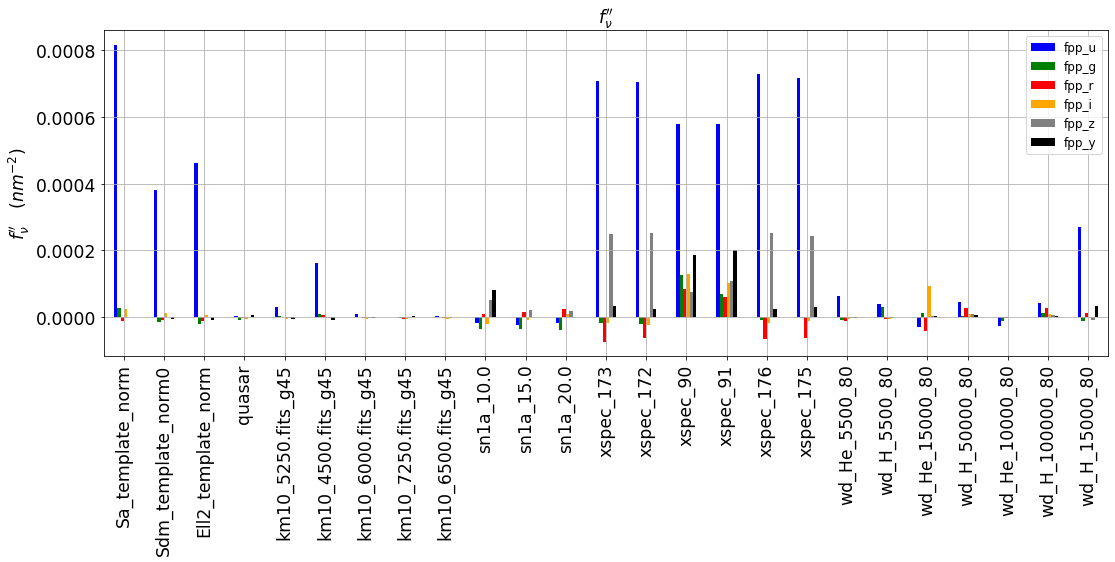

In [89]:
my_colors = list(islice(cycle(['b', 'g', 'r', 'orange','grey','k']), None, len(df_fpp)))
df_fpp.plot.bar(figsize=(18,6),ylabel="$f^{\prime\prime}_\\nu \quad (nm^{-2})$",grid=True,color=my_colors,title="$f_\\nu^{\prime\prime}$")

## Merge the three dataframe

In [90]:
df_SED_infos=pd.concat([df_SED,df_fp,df_fpp],axis=1)

In [91]:
df_SED_infos

type      fp_u      fp_g      fp_r      fp_i  \
Sa_template_norm           galaxies  0.014306  0.008547  0.002844  0.002649   
Sdm_template_norm0         galaxies  0.010860  0.003987  0.001750  0.001753   
Ell2_template_norm         galaxies  0.014341  0.006005  0.001870  0.001270   
quasar                       quasar  0.003326  0.001947  0.000775  0.000516   
km10_5250.fits_g45            stars  0.005114  0.003498  0.002283  0.001227   
km10_4500.fits_g45            stars  0.006372  0.004272  0.002939  0.001961   
km10_6000.fits_g45            stars  0.004269  0.002959  0.001739  0.000667   
km10_7250.fits_g45            stars  0.003431  0.002358  0.001123 -0.000107   
km10_6500.fits_g45            stars  0.003866  0.002683  0.001449  0.000341   
sn1a_10.0                        sn  0.003489  0.000853 -0.001154 -0.002957   
sn1a_15.0                        sn  0.003937  0.000748 -0.002065 -0.002479   
sn1a_20.0                        sn  0.004263  0.001236 -0.002352 -0.002940   
xspec_173           photoZ_outliers  0.004547  0.001143  0.001475  0.001794   
xspec_172           photoZ_outliers  0.003926  0.000696  0.001169  0.001567   
xspec_90            photoZ_outliers  0.020093  0.007143  0.003538  0.002193   
xspec_91            photoZ_outliers  0.020620  0.007497  0.003793  0.002361   
xspec_176           photoZ_outliers  0.006403  0.002486  0.002389  0.002474   
xspec_175           photoZ_outliers  0.005785  0.002038  0.002086  0.002248   
wd_He_5500_80           white_dwarf  0.012813  0.005625  0.001918  0.000607   
wd_H_5500_80            white_dwarf  0.009869  0.004864  0.001935  0.000783   
wd_He_15000_80          white_dwarf -0.000836 -0.001312 -0.001939 -0.001700   
wd_H_50000_80           white_dwarf -0.004506 -0.003360 -0.002984 -0.002476   
wd_He_10000_80          white_dwarf  0.002238  0.000139 -0.000867 -0.001139   
wd_H_100000_80          white_dwarf -0.004912 -0.003766 -0.003050 -0.002521   
wd_H_15000_80           white_dwarf  0.000538  0.000450 -0.002334 -0.001910   

                        fp_z      fp_y         fpp_u         fpp_g  \
Sa_template_norm    0.002083  0.001375  8.152355e-04  2.714474e-05   
Sdm_template_norm0  0.001762  0.001118  3.805480e-04 -1.529182e-05   
Ell2_template_norm  0.001197  0.000739  4.626918e-04 -2.036808e-05   
quasar              0.000041  0.000484  4.489962e-06 -7.887685e-06   
km10_5250.fits_g45  0.000612  0.000162  3.103848e-05  2.237550e-06   
km10_4500.fits_g45  0.001412  0.000867  1.616969e-04  8.044571e-06   
km10_6000.fits_g45  0.000075 -0.000287  9.310265e-06 -3.788253e-08   
km10_7250.fits_g45 -0.000626 -0.000824 -2.643204e-07 -2.071222e-06   
km10_6500.fits_g45 -0.000216 -0.000517  4.113654e-06 -1.011106e-06   
sn1a_10.0          -0.007070 -0.004344 -1.647512e-05 -3.507753e-05   
sn1a_15.0          -0.003088 -0.002754 -2.244960e-05 -3.455098e-05   
sn1a_20.0          -0.002310 -0.002469 -1.762039e-05 -3.813229e-05   
xspec_173           0.001066  0.001464  7.088329e-04 -1.681232e-05   
xspec_172           0.000896  0.001328  7.050247e-04 -2.101771e-05   
xspec_90            0.001735  0.001329  5.793595e-04  1.251035e-04   
xspec_91            0.001873  0.001416  5.777133e-04  7.027946e-05   
xspec_176           0.001574  0.001868  7.273212e-04 -8.104036e-06   
xspec_175           0.001406  0.001734  7.155686e-04 -3.766644e-06   
wd_He_5500_80       0.000040 -0.000243  6.192754e-05 -7.900615e-06   
wd_H_5500_80        0.000259 -0.000006  3.986614e-05  3.023047e-05   
wd_He_15000_80     -0.001665 -0.001558 -2.974756e-05  1.139148e-05   
wd_H_50000_80      -0.002161 -0.001934  4.556482e-05  4.649726e-06   
wd_He_10000_80     -0.001207 -0.001209 -2.700908e-05 -1.165847e-05   
wd_H_100000_80     -0.002193 -0.001965  4.233021e-05  1.105990e-05   
wd_H_15000_80      -0.001608 -0.001614  2.708031e-04 -1.290844e-05   

                           fpp_r         fpp_i         fpp_z         fpp_y  
Sa_template_norm   -1.152436e-05  2.408883e-05 -7.716548e-07  3.499770e-09  
S

# Photometric correction - Color effect vs airmass

In [92]:
all_II_diff[1]

II0       II1        II2      II10      II20
0  0.001979  0.003178   0.745412 -0.042766 -0.051342
1  0.005597 -0.013557  10.402443 -0.212616 -1.267565
2  0.003224 -0.008314   5.350986 -0.114995 -0.300265
3  0.001926 -0.003624   2.718528 -0.052355 -0.146988
4  0.001108 -0.002260   1.044317 -0.034580 -0.059196
5  0.000446 -0.000085   0.519332 -0.044398 -1.055004

## Photometric corretion with $f_\nu^\prime$ only

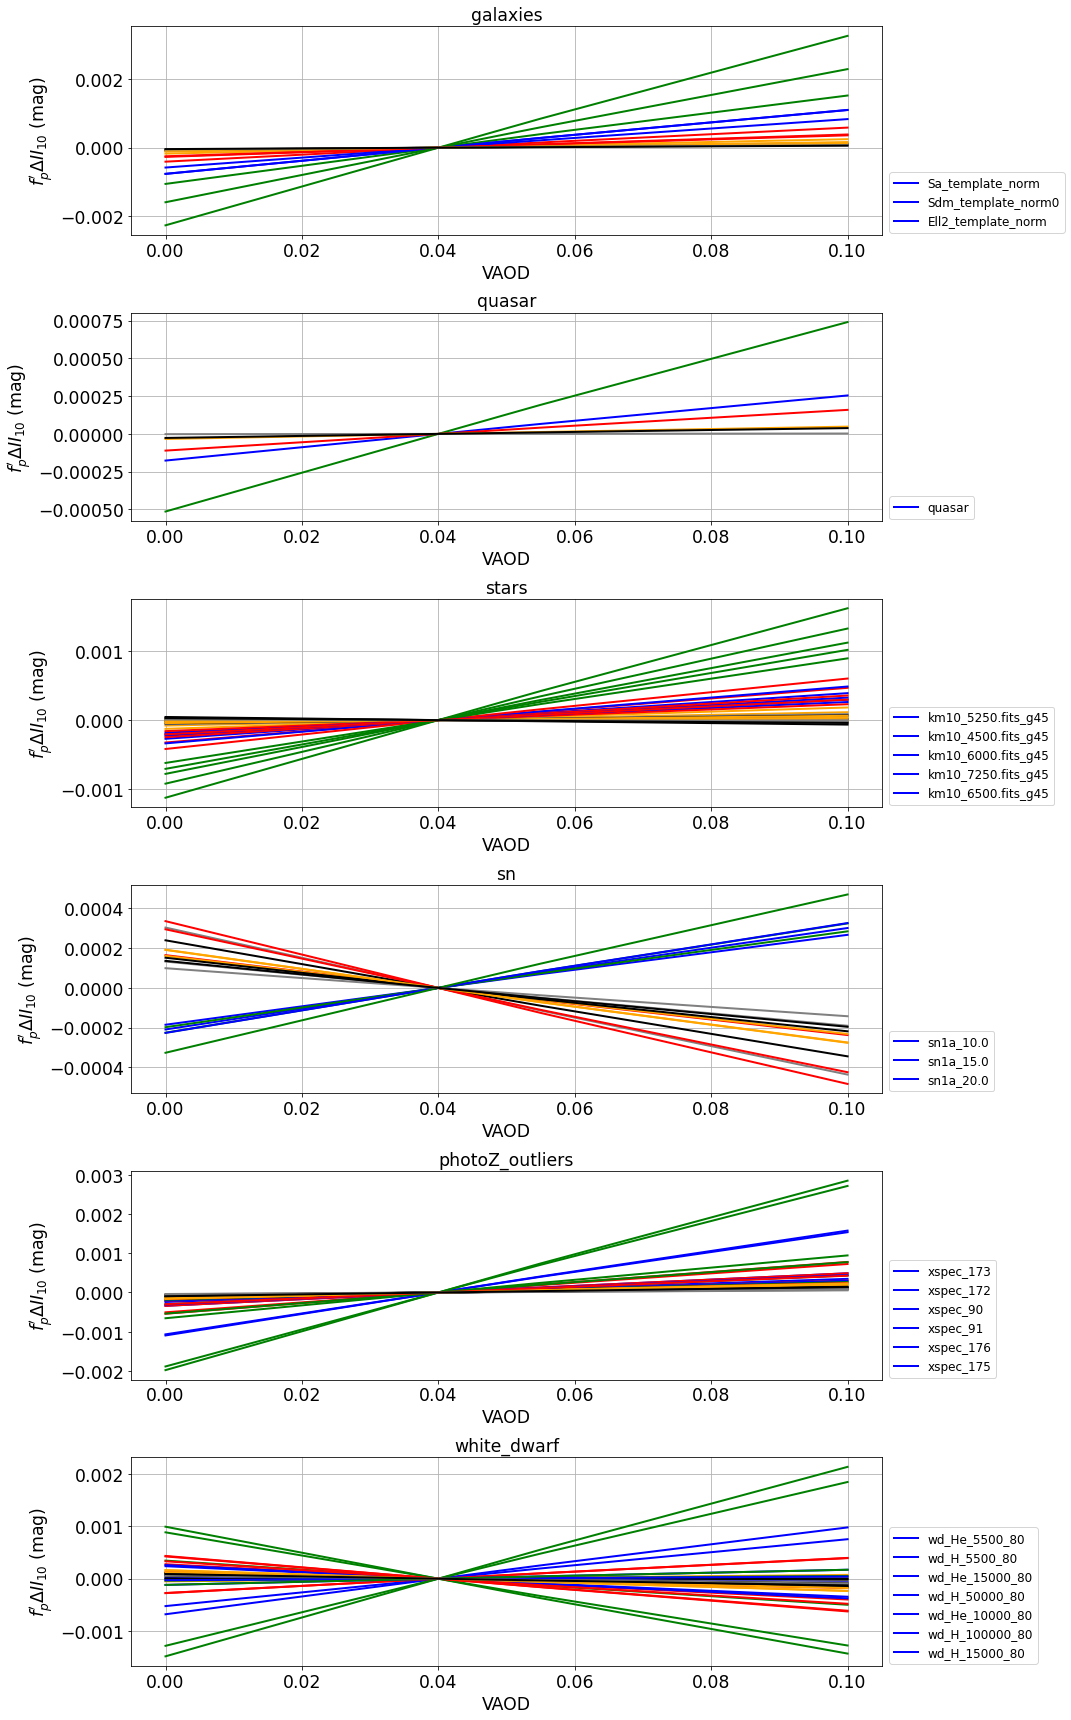

In [93]:
fig, axs = plt.subplots(NSEDTYPES,1,figsize=(15,NSEDTYPES*4))

old_type = None
idx_sed = -1

# loop on SED
for index_name, row in df_SED_infos.iterrows():
    the_type = row["type"]
    if the_type != old_type:
        idx_sed+=1
        old_type = the_type
        #print(f"new type {the_type} !!!")
        
    #print("\t",index_name,row["type"])
    for ifilt in range(NFILT):
        coeff_tag = "fp_"+ filter_tagnames[ifilt]
        coeff_value = df_SED_infos.loc[index_name][coeff_tag]
        DeltaMag = np.zeros(NAER)
        for idx_aer,aer in enumerate(all_aer):
            Delta_II10 = all_II_diff[idx_aer].loc[ifilt]["II10"]
            DeltaMag[idx_aer] =  1.087*(Delta_II10*coeff_value)
        if ifilt==0:
            axs[idx_sed].plot(all_aer,DeltaMag,color=filter_color[ifilt],label=index_name,lw=2) 
        else:
            axs[idx_sed].plot(all_aer,DeltaMag,color=filter_color[ifilt],lw=2)
        
    axs[idx_sed].legend(loc=(1.01, 0.01))
    axs[idx_sed].set_xlabel("VAOD")
    axs[idx_sed].set_ylabel("$f^\prime_p \Delta II_{10}$ (mag)")
    axs[idx_sed].set_title(the_type)
    axs[idx_sed].grid()
            
plt.tight_layout()        
        

## Photometric correction with $f_\nu^\prime$ and $f_\nu^{\prime\prime}$ 

### Build the columns tags

In [94]:
from collections import OrderedDict

In [95]:
all_columns = OrderedDict()
all_columns["name"] = 'str'
all_columns["type"] = 'str'
all_columns["filter"] = 'str'
for tag in all_aer_tags:
    all_columns[f"c_1_{tag}"] = 'float'
    all_columns[f"c_2_{tag}"] = 'float'
    all_columns[f"c_3_{tag}"] = 'float'
    all_columns[f"c_t_{tag}"] = 'float'
print(all_columns)
print(len(all_columns))

OrderedDict([('name', 'str'), ('type', 'str'), ('filter', 'str'), ('c_1_aer_0', 'float'), ('c_2_aer_0', 'float'), ('c_3_aer_0', 'float'), ('c_t_aer_0', 'float'), ('c_1_aer_5', 'float'), ('c_2_aer_5', 'float'), ('c_3_aer_5', 'float'), ('c_t_aer_5', 'float'), ('c_1_aer_10', 'float'), ('c_2_aer_10', 'float'), ('c_3_aer_10', 'float'), ('c_t_aer_10', 'float'), ('c_1_aer_15', 'float'), ('c_2_aer_15', 'float'), ('c_3_aer_15', 'float'), ('c_t_aer_15', 'float'), ('c_1_aer_20', 'float'), ('c_2_aer_20', 'float'), ('c_3_aer_20', 'float'), ('c_t_aer_20', 'float'), ('c_1_aer_25', 'float'), ('c_2_aer_25', 'float'), ('c_3_aer_25', 'float'), ('c_t_aer_25', 'float'), ('c_1_aer_30', 'float'), ('c_2_aer_30', 'float'), ('c_3_aer_30', 'float'), ('c_t_aer_30', 'float'), ('c_1_aer_35', 'float'), ('c_2_aer_35', 'float'), ('c_3_aer_35', 'float'), ('c_t_aer_35', 'float'), ('c_1_aer_40', 'float'), ('c_2_aer_40', 'float'), ('c_3_aer_40', 'float'), ('c_t_aer_40', 'float'), ('c_1_aer_45', 'float'), ('c_2_aer_45', 'f

### Book the dataframe

In [96]:
all_II_diff[15]

II0       II1       II2      II10      II20
0 -0.001854 -0.003086 -0.698396  0.041464  0.050842
1 -0.005340  0.011092 -9.930379  0.206061  1.266969
2 -0.003156  0.007298 -5.238674  0.111315  0.301739
3 -0.001923  0.003291 -2.714615  0.050626  0.144395
4 -0.001123  0.002126 -1.059334  0.033438  0.058339
5 -0.000461 -0.000032 -0.539513  0.042959  1.023510

In [97]:
df_pc_col_aerosols = pd.DataFrame(columns=all_columns)

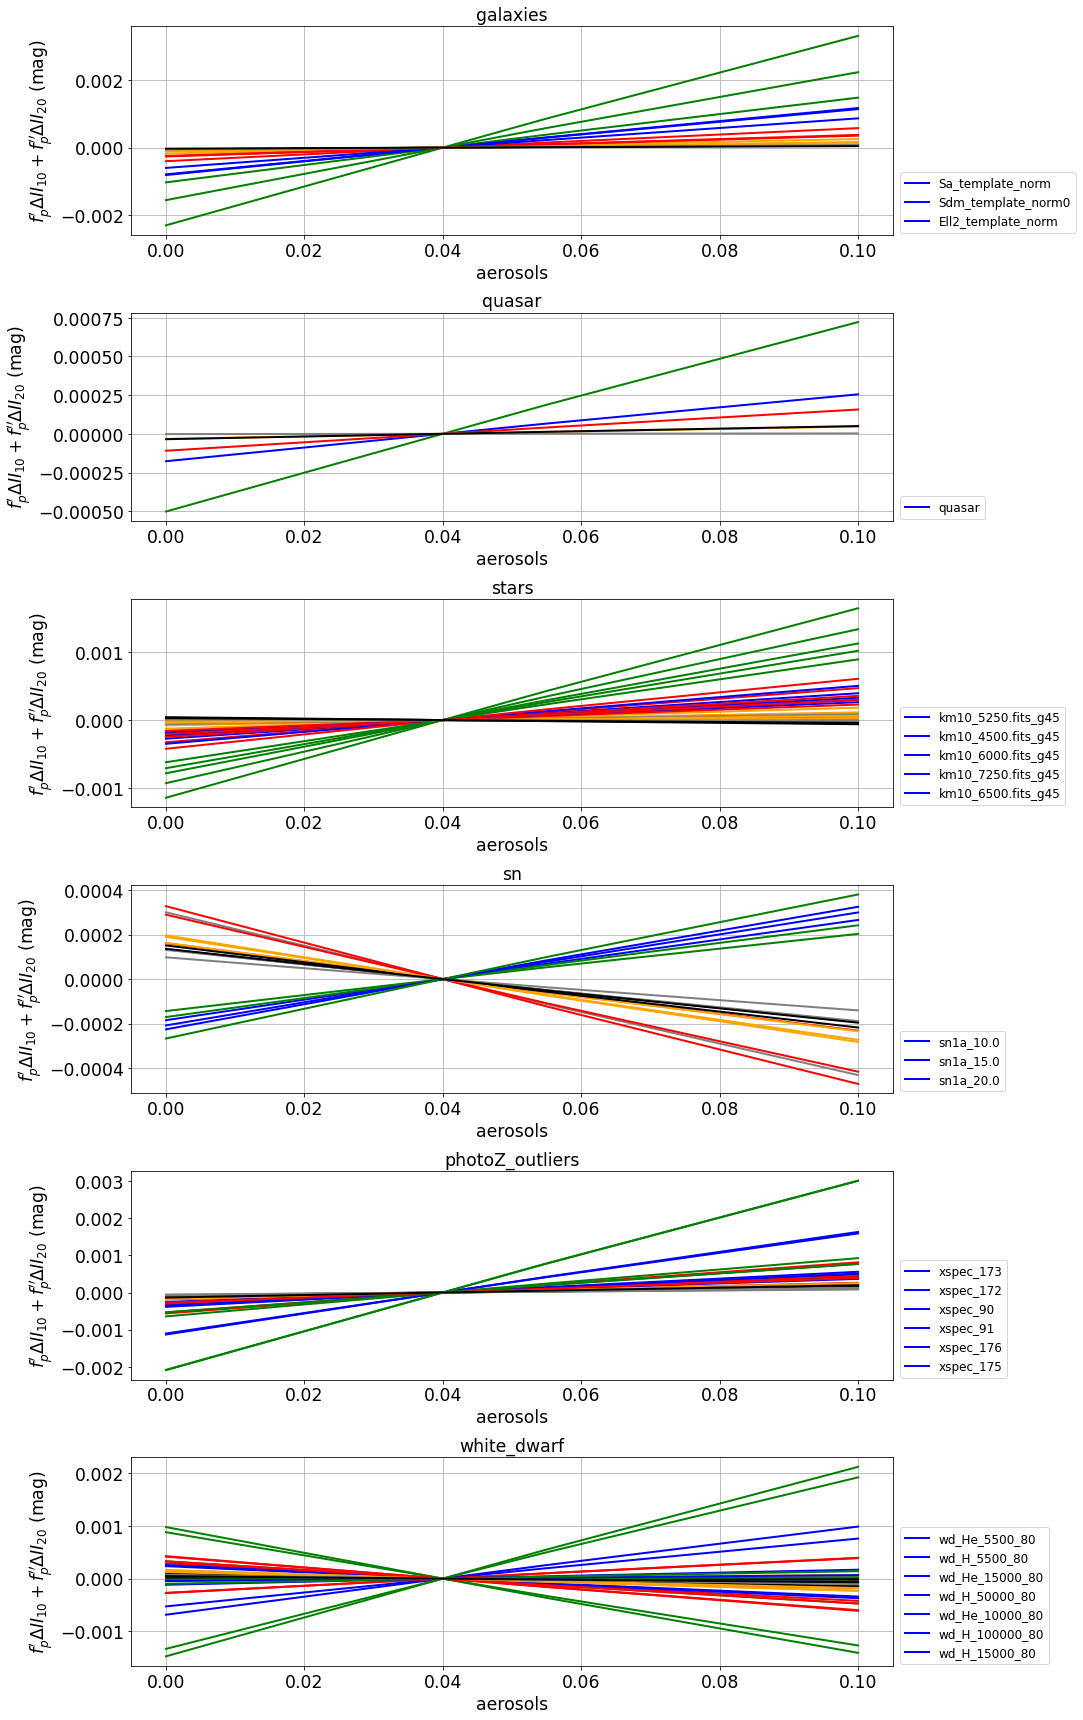

In [98]:
fig, axs = plt.subplots(NSEDTYPES,1,figsize=(15,NSEDTYPES*4))
K=1.087


old_type = None
idx_sed = -1
idx_type = -1

# loop on SED
for index_name, row in df_SED_infos.iterrows():
    idx_sed += 1
    the_type = row["type"]
    if the_type != old_type:
        idx_type+=1
        old_type = the_type
        #print(f"new type {the_type} !!!")
        
    #print("\t",index_name,row["type"])
    for ifilt in range(NFILT):
        
        list_to_pandas = [index_name, the_type, filter_tagnames[ifilt]]
        
        coeff_tag1 = "fp_"+ filter_tagnames[ifilt]
        coeff_value1 = df_SED_infos.loc[index_name][coeff_tag1]
        coeff_tag2 = "fpp_"+ filter_tagnames[ifilt]
        coeff_value2 = df_SED_infos.loc[index_name][coeff_tag2]
        
        
        # init before loop on airlass
        DeltaMag = np.zeros(NAER)
        # container for mags corrections
        list_data_values = []
        
        # loop on aerosols to fill DeltaMag[idx_am] and data_to_pandas
        
        for idx_aer,aer in enumerate(all_aer):
            # get integral difference between observed and standard
            Delta_II10 = all_II_diff[idx_aer].loc[ifilt]["II10"]
            Delta_II20 = all_II_diff[idx_aer].loc[ifilt]["II20"]
            
            c1 = K*Delta_II10*coeff_value1
            c2 = K*Delta_II20*coeff_value2
            c3 = -K/2*(Delta_II10*coeff_value1)**2
            c4 = c1+c2+c3
            
    
            # fill container for mag correction
            list_data_values.append(c1)
            list_data_values.append(c2)
            list_data_values.append(c3)
            list_data_values.append(c4)
            
            # array for plotting     
            DeltaMag[idx_aer] = c4
 

        # make the list
        list_to_pandas = list_to_pandas +  list_data_values
                              
        # add the row to pandas dataframe
        df_pc_col_aerosols.loc[idx_sed*6+ifilt] = list_to_pandas
              
              
        # plot for this airmass  for this SED  
        if ifilt==0:
            axs[idx_type].plot(all_aer,DeltaMag,color=filter_color[ifilt],label=index_name,lw=2) 
        else:
            axs[idx_type].plot(all_aer,DeltaMag,color=filter_color[ifilt],lw=2)
            
        
        
    
    axs[idx_type].legend(loc=(1.01, 0.01))
    axs[idx_type].set_xlabel("aerosols")
    axs[idx_type].set_ylabel("$f^\prime_p \Delta II_{10}+ f^{\prime\prime}_p \Delta II_{20} $ (mag)")
    axs[idx_type].set_title(the_type)
    axs[idx_type].grid()
            
plt.tight_layout()        
        

In [99]:
df_pc_col_aerosols

name         type filter  c_1_aer_0     c_2_aer_0  \
0    Sa_template_norm     galaxies      u  -0.000760 -5.184938e-05   
1    Sa_template_norm     galaxies      g  -0.002257 -4.264675e-05   
2    Sa_template_norm     galaxies      r  -0.000406  4.286661e-06   
3    Sa_template_norm     galaxies      i  -0.000172 -4.393131e-06   
4    Sa_template_norm     galaxies      z  -0.000089  5.666778e-08   
..                ...          ...    ...        ...           ...   
145     wd_H_15000_80  white_dwarf      g  -0.000119  2.028029e-05   
146     wd_H_15000_80  white_dwarf      r   0.000333 -4.935277e-06   
147     wd_H_15000_80  white_dwarf      i   0.000124  3.284283e-07   
148     wd_H_15000_80  white_dwarf      z   0.000069  5.839116e-07   
149     wd_H_15000_80  white_dwarf      y   0.000089 -4.160350e-05   

        c_3_aer_0  c_t_aer_0  c_1_aer_5     c_2_aer_5     c_3_aer_5  ...  \
0   -2.657475e-07  -0.000812  -0.000665 -4.549726e-05 -2.034480e-07  ...   
1   -2.343964e-06  -0.002302  -0.001975 -3.740120e-05 -1.794635e-06  ...   
2   -7.590355e-08  -0.000402  -0.000355  3.761419e-06 -5.811398e-08  ...   
3   -1.365506e-08  -0.000177  -0.000151 -3.848813e-06 -1.045477e-08  ...   
4   -3.681812e-09  -0.000089  -0.000078  4.965307e-08 -2.818895e-09  ...   
..            ...        ...        ...           ...           ...  ...   
145 -6.490409e-09  -0.000099  -0.000104  1.778581e-05 -4.969323e-09  ...   
146 -5.115688e-08   0.000329   0.000292 -4.330560e-06 -3.916721e-08  ...   
147 -7.098202e-09   0.000125   0.000109  2.877353e-07 -5.434616e-09  ...   
148 -2.194377e-09   0.000070   0.000060  5.116312e-07 -1.680075e-09  ...   
149 -3.644171e-09   0.000047   0.000078 -3.641147e-05 -2.790358e-09  ...   

       c_3_aer_90  c_t_aer_90  c_1_aer_95    c_2_aer_95    c_3_aer_95  \
0   -3.852675e-07    0.000979    0.001005  7.064876e-05 -4.648168e-07   
1   -3.395232e-06    0.002767    0.002984  5.876140e-05 -4.096190e-06   
2   -1.096217e-07    0.000483    0.000536 -5.949741e-06 -1.322376e-07   
3   -1.967073e-08    0.000212    0.000227  5.916122e-06 -2.372684e-08   
4   -5.303798e-09    0.000107    0.000118 -7.662600e-08 -6.397427e-09   
..            ...         ...         ...           ...           ...   
145 -9.401357e-09    0.000118    0.000157 -2.794347e-05 -1.134230e-08   
146 -7.388196e-08   -0.000395   -0.000440  6.849998e-06 -8.912447e-08   
147 -1.022527e-08   -0.000150   -0.000164 -4.422863e-07 -1.233373e-08   
148 -3.161089e-09   -0.000084   -0.000091 -7.895635e-07 -3.812897e-09   
149 -5.258001e-09   -0.000057   -0.000117  5.508251e-05 -6.342643e-09   

     c_t_aer_95  c_1_aer_100   c_2_aer_100   c_3_aer_100  c_t_aer_100  
0      0.001075     0.001095  7.713695e-05 -5.519112e-07     0.001172  
1      0.003039     0.003252  6.416292e-05 -4.863696e-06     0.003311  
2      0.000530     0.000584 -6.498869e-06 -1.570001e-07     0.000578  
3      0.000233     0.000247  6.453114e-06 -2.816744e-08     0.000254  
4      0.000118     0.000128 -8.360439e-08 -7.594786e-09     0.000128  
..          ...          ...           ...           ...          ...  
145    0.000129     0.000171 -3.051211e-05 -1.346752e-08     0.000141  
146   -0.000433    -0.000480  7.482214e-06 -1.058137e-07    -0.000472  
147   -0.000164    -0.000178 -4.824315e-07 -1.464205e-08    -0.000179  
148   -0.000092    -0.000099 -8.614697e-07 -4.526529e-09    -0.000100  
149   -0.000062    -0.000128  6.002934e-05 -7.530448e-09    -0.000068  

[150 rows x 87 columns]

## Error on SED approximation

### Error on Color Photometric Correction bias due to SED approximation
$$
\begin{eqnarray}
\Delta m & = & \left| 2.5 \log_{10}\left(
\frac{\mathbb{I}_0^{std}(b)}
{\mathbb{I}_0^{obs}(b)}\right) +
2.5 \log_{10} 
	\left( 
	\frac{\int_0^\infty F_\nu(\lambda) \times S_b^{obs}(\lambda) \frac{d\lambda}{\lambda} }{\int_0^\infty F_\nu(\lambda) \times S_b^{std}(\lambda) \frac{d\lambda}{\lambda}} 
	\right) \right. \nonumber \\
    & & \left. - 1.087\left( f_\nu^\prime(\lambda_b) \Delta \mathbb{I}_{10}(b) +
          \frac{f_\nu^{\prime\prime}(\lambda_b)}{2}\Delta \mathbb{I}_{20}(b) \right. 
         - \left. \frac{1}{2}\left( f_\nu^\prime(\lambda_b) \Delta \mathbb{I}_{10}(b) \right)^2             
          \right)\right|
\end{eqnarray}  
$$

$$
\begin{eqnarray}
\Delta m & = & \left| 
2.5 \log_{10} 
	\left( 
	\frac{\int_0^\infty F_\nu(\lambda) \times \phi_b^{obs}(\lambda) d\lambda}{\int_0^\infty F_\nu(\lambda) \times \phi_b^{std}(\lambda)d\lambda} 
	\right) \right. \nonumber \\
    & & \left. - 1.087\left( f_\nu^\prime(\lambda_b) \Delta \mathbb{I}_{10}(b) +
          \frac{f_\nu^{\prime\prime}(\lambda_b)}{2}\Delta \mathbb{I}_{20}(b) \right. 
         - \left. \frac{1}{2}\left( f_\nu^\prime(\lambda_b) \Delta \mathbb{I}_{10}(b) \right)^2             
          \right)\right|
\end{eqnarray}  
$$

In [100]:
all_columns = OrderedDict()
all_columns["name"] = 'str'
all_columns["type"] = 'str'
all_columns["filter"] = 'str'
for tag in all_aer_tags:
    all_columns[f"ct_{tag}"] = 'float'
print(all_columns)
print(len(all_columns))

OrderedDict([('name', 'str'), ('type', 'str'), ('filter', 'str'), ('ct_aer_0', 'float'), ('ct_aer_5', 'float'), ('ct_aer_10', 'float'), ('ct_aer_15', 'float'), ('ct_aer_20', 'float'), ('ct_aer_25', 'float'), ('ct_aer_30', 'float'), ('ct_aer_35', 'float'), ('ct_aer_40', 'float'), ('ct_aer_45', 'float'), ('ct_aer_50', 'float'), ('ct_aer_55', 'float'), ('ct_aer_60', 'float'), ('ct_aer_65', 'float'), ('ct_aer_70', 'float'), ('ct_aer_75', 'float'), ('ct_aer_80', 'float'), ('ct_aer_85', 'float'), ('ct_aer_90', 'float'), ('ct_aer_95', 'float'), ('ct_aer_100', 'float')])
24


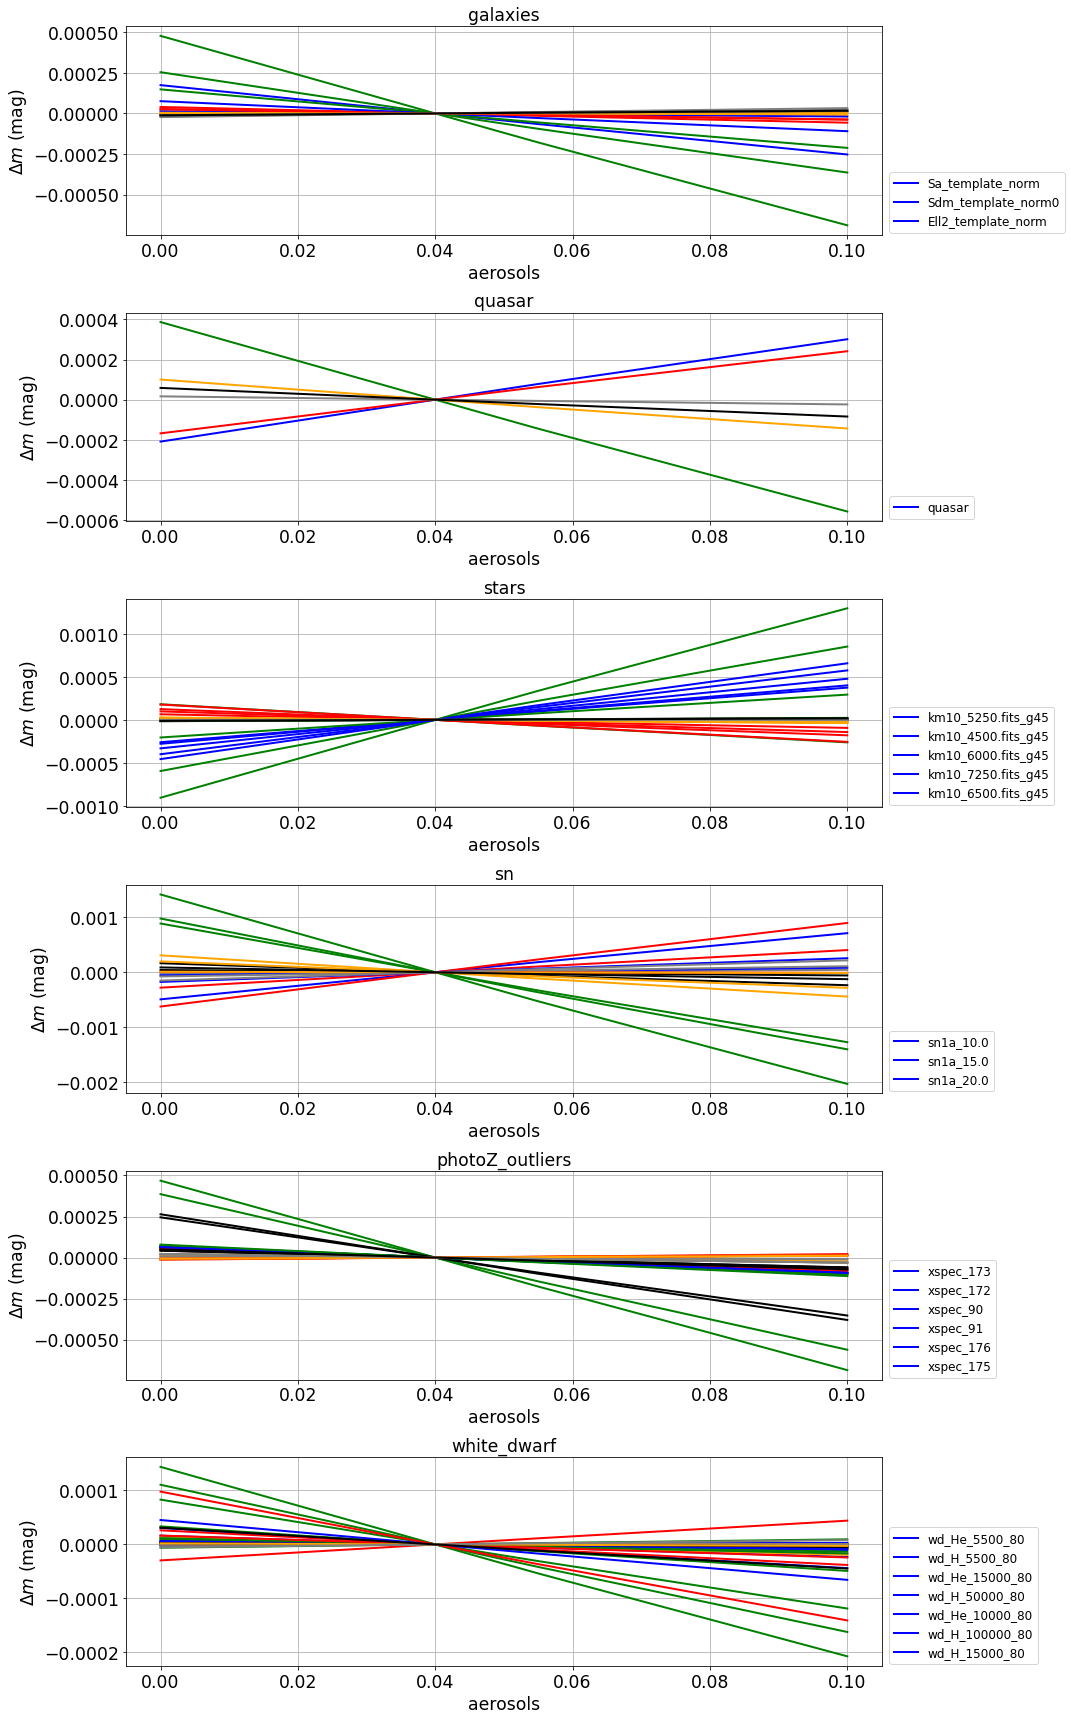

In [101]:
df_pc_col_bias_aerosols = pd.DataFrame(columns=all_columns)

fig, axs = plt.subplots(NSEDTYPES,1,figsize=(15,NSEDTYPES*4))
K=1.087

old_type = None
idx_sed = -1


# loop on SED types
for idx_type,sed_type in enumerate(sedtypes):
    
    sednamelist = sedtypeslists[sed_type] 
    NSEDs = len(sednamelist)
    
    
    # loop on objects in sedtypes
    for idx0,sed_name in  enumerate(sednamelist):
        
        idx_sed+=1 
        
        wavel,fnu = seds[sed_name].getSED_fnu()
        
        # loop on filters
        for ifilt in range(NFILT):
            
            list_to_pandas = [sed_name, sed_type, filter_tagnames[ifilt]]
            
            coeff_tag1 = "fp_"+ filter_tagnames[ifilt]
            coeff_value1 = df_SED_infos.loc[sed_name][coeff_tag1]
            coeff_tag2 = "fpp_"+ filter_tagnames[ifilt]
            coeff_value2 = df_SED_infos.loc[sed_name][coeff_tag2]
            
            # init before loop on airlass
            DeltaMag = np.zeros(NAER)
            # container for mags corrections
            list_data_values = []
            
            #print(list_to_pandas)
            
            # loop on aerosols
            for idx_aer,aer in enumerate(all_aer):
                #print(all_df_obs[idx_am].head())
                # get integral difference between observed and standard
                
                #approximation
                Delta_II10 = all_II_diff[idx_aer].loc[ifilt]["II10"]
                Delta_II20 = all_II_diff[idx_aer].loc[ifilt]["II20"]
            
                c1 = K*Delta_II10*coeff_value1
                c2 = K*Delta_II20*coeff_value2
                c3 = -K/2*(Delta_II10*coeff_value1)**2
                c4 = c1+c2+c3
                
                # compute the true integral
                the_df_obs=all_df_obs[idx_aer]
                result_integ1 = ComputeAverage(wavel,fnu,the_df_obs)
                result_integ2 = ComputeAverage(wavel,fnu,df_std)
                
                dm=2.5*np.log10(result_integ1[ifilt]/result_integ2[ifilt]) - c4
                
                list_data_values.append(dm)
                DeltaMag[idx_aer] = dm
            
            
            # make the list
            list_to_pandas = list_to_pandas +  list_data_values
            
            # add the row to pandas dataframe
            df_pc_col_bias_aerosols.loc[idx_sed*6+ifilt] = list_to_pandas
            
            # plot for this airmass  for this SED  
            if ifilt==0:
                axs[idx_type].plot(all_aer,DeltaMag,color=filter_color[ifilt],label=sed_name,lw=2) 
            else:
                axs[idx_type].plot(all_aer,DeltaMag,color=filter_color[ifilt],lw=2)
            
        
        
    
    axs[idx_type].legend(loc=(1.01, 0.01))
    axs[idx_type].set_xlabel("aerosols")
    axs[idx_type].set_ylabel("$\Delta m$ (mag)")
    axs[idx_type].set_title(sed_type)
    axs[idx_type].grid()
            
plt.tight_layout()                
        

In [102]:
df_pc_col_bias_aerosols

name         type filter  ct_aer_0  ct_aer_5  ct_aer_10  \
0    Sa_template_norm     galaxies      u  0.000174  0.000153   0.000131   
1    Sa_template_norm     galaxies      g  0.000478  0.000418   0.000358   
2    Sa_template_norm     galaxies      r  0.000040  0.000035   0.000030   
3    Sa_template_norm     galaxies      i  0.000011  0.000010   0.000009   
4    Sa_template_norm     galaxies      z -0.000023 -0.000020  -0.000017   
..                ...          ...    ...       ...       ...        ...   
145     wd_H_15000_80  white_dwarf      g  0.000144  0.000126   0.000108   
146     wd_H_15000_80  white_dwarf      r  0.000098  0.000086   0.000073   
147     wd_H_15000_80  white_dwarf      i  0.000002  0.000002   0.000001   
148     wd_H_15000_80  white_dwarf      z -0.000005 -0.000005  -0.000004   
149     wd_H_15000_80  white_dwarf      y  0.000031  0.000027   0.000023   

     ct_aer_15     ct_aer_20     ct_aer_25     ct_aer_30  ...     ct_aer_55  \
0     0.000109  8.735710e-05  6.555665e-05  4.373347e-05  ... -6.563544e-05   
1     0.000299  2.389228e-04  1.792092e-04  1.194842e-04  ... -1.789101e-04   
2     0.000025  1.991514e-05  1.493308e-05  9.953665e-06  ... -1.488186e-05   
3     0.000007  5.740817e-06  4.307190e-06  2.873217e-06  ... -4.307828e-06   
4    -0.000014 -1.139279e-05 -8.545436e-06 -5.697735e-06  ...  8.530423e-06   
..         ...           ...           ...           ...  ...           ...   
145   0.000090  7.188050e-05  5.391667e-05  3.594799e-05  ... -5.383753e-05   
146   0.000061  4.892726e-05  3.669858e-05  2.446879e-05  ... -3.663143e-05   
147   0.000001  9.655106e-07  7.237961e-07  4.823060e-07  ... -7.203206e-07   
148  -0.000003 -2.750710e-06 -2.063398e-06 -1.375980e-06  ...  2.060246e-06   
149   0.000019  1.552143e-05  1.164291e-05  7.763953e-06  ... -1.163230e-05   

        ct_aer_60  ct_aer_65  ct_aer_70  ct_aer_75  ct_aer_80  ct_aer_85  \
0   -8.634141e-05  -0.000107  -0.000128  -0.000149  -0.000169  -0.000190   
1   -2.355857e-04  -0.000292  -0.000349  -0.000406  -0.000462  -0.000519   
2   -1.958196e-05  -0.000024  -0.000029  -0.000034  -0.000038  -0.000043   
3   -5.669143e-06  -0.000007  -0.000008  -0.000010  -0.000011  -0.000012   
4    1.122320e-05   0.000014   0.000017   0.000019   0.000022   0.000025   
..            ...        ...        ...        ...        ...        ...   
145 -7.089465e-05  -0.000088  -0.000105  -0.000122  -0.000139  -0.000156   
146 -4.821487e-05  -0.000060  -0.000071  -0.000083  -0.000095  -0.000106   
147 -9.472307e-07  -0.000001  -0.000001  -0.000002  -0.000002  -0.000002   
148  2.710728e-06   0.000003   0.000004   0.000005   0.000005   0.000006   
149 -1.530538e-05  -0.000019  -0.000023  -0.000026  -0.000030  -0.000034   

     ct_aer_90  ct_aer_95  ct_aer_100  
0    -0.000211  -0.000232   -0.000253  
1    -0.000576  -0.000632   -0.000689  
2    -0.000048  -0.000052   -0.000057  
3    -0.000014  -0.000015   -0.000017  
4     0.000027   0.000030    0.000033  
..         ...        ...         ...  
145  -0.000173  -0.000190   -0.000207  
146  -0.000118  -0.000129   -0.000141  
147  -0.000002  -0.000003   -0.000003  
148   0.000007   0.000007    0.000008  
149  -0.000037  -0.000041   -0.000045  

[150 rows x 24 columns]